In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import netCDF4 as nc
import time as clk
from cftime import num2pydate
import copy#pour copier des objets 
from tqdm.notebook import tqdm#pour barre de progression 
import xarray as xr
import MRD_v3 as MRD
repertoire_courant=os.getcwd()
print(repertoire_courant)

#on prend la tour 2, bas, ouest
nom_T2_LW=r'\tower2-left-west.nc'
nom_T2_TO5=r'\T2_TO5.nc'
nom_T2_LE=r'\tower2-right-east.nc'
t1=clk.time()
t0=clk.time()
print("chargement des données (cela peut prendre du temps)")

t1=clk.time()
print(f"fichier {nom_T2_TO5}")
r_T2_TO5=nc.Dataset(repertoire_courant+nom_T2_TO5,'r')
time_IRGA=pd.to_datetime(num2pydate(r_T2_TO5['TIMESTAMP'],r_T2_TO5['TIMESTAMP'].units,calendar='standard'),format='mixed')
print(f"fait en {clk.time()-t1} s")
t1=clk.time()


print(f"fait en {clk.time()-t1} s")
print(f"temps total : {clk.time()-t0} s")

C:\Users\evanl\Documents\Stage IGE
chargement des données (cela peut prendre du temps)
fichier \T2_TO5.nc
fait en 79.98288249969482 s
fait en 0.0 s
temps total : 79.99884223937988 s


In [2]:
def Dataset_to_Series(Ds,tps,variables=None,var_date='TIMESTAMP'):
    """retourne un dictionnaire avec pour clés les noms des variables et pour valeurs des séries temporelles"""
    dic_vars={}
    #if tps==None : tps=pd.to_datetime(num2pydate(Ds[var_date],Ds[var_date].units,calendar='standard'),format='mixed')
    if isinstance(variables,list)==True:
        #verification que les éléments se trouvent bien dans la liste
        var_erreur=[]
        for var in variables :
            if var not in Ds.variables : var_erreur.append(var)
        if var_erreur !=[]:raise ValueError(f"{var_erreur} ne sont pas dans {Ds.variables.keys()}")
        
        for var in Ds.variables:
            if var in variables:
                dic_vars[var]=pd.Series(Ds[var][:],index=tps)
            else:
                pass
    else :
        for var in Ds.variables:
            if var==var_date:
                pass
            else:
                dic_vars[var]=pd.Series(Ds[var][:],index=tps)
    return dic_vars

def modifier_series(ser,action,*args,**kwargs):
    "Applique une fonction (action) sur la série, avec des paramètres positionnels et nominaux"
    new_serie=copy.deepcopy(ser)
    for var in ser:
        if isinstance(ser[var],pd.Series):
            new_serie[var]=action(ser[var],*args,**kwargs)
        else : pass
    return new_serie

def renommer_cle_dic(dic,cle_remplace):
    "retourne un dictionnaire avec des cles renommées"
    for cle in cle_remplace:
        dic[cle_remplace[cle]]=dic[cle]
        del dic[cle] #suppression de l'ancienne clé
    return dic

def series_to_arrays(ser):
    "récupère les valeurs des séries sous forme de tableaux"
    return modifier_series(ser, lambda x: x.values)

def modifier_arrays(array,action,*args,ignore=None):
    "Applique une fonction (action) sur les arrays, avec un parametre (idem que pour les series)"
    #A FAIRE : pour le paramètre 'ignore', passer en argument une fonction lambda retournant un booléen
    # exemple : ignore = lambda x:x in [
    new_array=copy.deepcopy(array)
    var_erreur=[]
    if isinstance(ignore,list)==True:
        for variables in ignore:
            print(variables)
            if variables not in new_array.keys():
                var_erreur.append(variables)
        if var_erreur != [] : raise KeyError(f"{var_erreur} not in {array.keys()}")
    for var in array:
        if ((isinstance(array[var],list)==True) or (isinstance(array[var],np.ndarray)==True)):
            #print(f"variable modifiee {var}")
            ignorer_it=True if ((isinstance(ignore,list)==True and var in ignore) or var==ignore) else False
            if ignorer_it==True:
                pass
            else:
                new_array[var]=action(array[var],*args)
            #print("on a bien un array")
        else :
            pass
    return new_array

#fonctions pour changer de repère horizontal
#A FAIRE : implémenter méthode double rotation (annuler <v> et <w>), et simple rotation (annuler que <w>)
#           cf Kaimal et Finnigan 1994, Vickers and Mahrt 2003
#Eventuellement implémenter contrôles qualité, cf Blein 2016, Mahrt and Jaot 1997

def rotation(x,y,theta):#theta en degrés
    "matrice de rotation : tourne un vecteur (x,y) d'un angle theta (en degrés)"
    new_x=copy.deepcopy(x)
    new_y=copy.deepcopy(y)
    theta_rad=np.radians(theta)
    cos_theta=np.cos(theta_rad)
    sin_theta=np.sin(theta_rad)
    return new_x*cos_theta-new_y*sin_theta,new_x*sin_theta+new_y*cos_theta
def angle(x,y):
    "retourne simplement un angle (en degrés), (équivalent  de l'argument d'un complexe koi"
    return np.degrees(np.arctan(y/x))
def rotation_level(level, orientation):
    "applique une rotation dans le plan (u,v) (usage : pour placer le repère dans le sens de la pente)"
    new_level=copy.deepcopy(level)
    u_rot,v_rot=rotation(new_level['u'],new_level['v'],orientation)
    new_level['u']=u_rot
    new_level['v']=v_rot
    new_level['dir']=orientation
    return new_level
def rotation_segments(x,y,theta):
    new_x=copy.deepcopy(x)
    new_y=copy.deepcopy(y)
    for i in range(0,len(x)):
        new_x[i],new_y[i]=rotation(x[i],y[i],theta[i])
    return new_x,new_y
        
def annulation_w(level):
    "applique une double rotation afin d'orienter le vecteur vitesse dans le sens du vent, de façon à avoir <w>=0"
    #Pour cela, on oriente  d'abord le repère dans le sens du vent, on annule <w>, puis on réoriente le repère dans le systeme de 
    #coordonnées horizontales du début
    new_level=copy.deepcopy(level)
    theta=np.degrees(np.arctan(np.nanmean(new_level['v'],axis=1)/np.nanmean(new_level['u'],axis=1)))
    new_level['u'],new_level['v']=rotation_segments(new_level['u'],new_level['v'],-theta)
    
    alpha=np.degrees(np.arctan(np.nanmean(new_level['w'],axis=1)/np.nanmean(new_level['u'],axis=1)))
    new_level['u'],new_level['w']=rotation_segments(new_level['u'],new_level['w'],-alpha)
    return new_level
def orientation_vent(level_moy,offset=0.0):
    "retourne l'orientation du vent, pour un tableau de valeurs moyennes"
    new_level=copy.deepcopy(level_moy)
    new_level['Wdir']=angle(new_level['v'],new_level['u'])+offset
    return new_level
def norme_vent(level_moy):
    "retourne la vitesse horizontale moyenne"
    new_level=copy.deepcopy(level_moy)
    new_level['Wspeed']=np.sqrt(new_level['u']**2+new_level['v']**2)
    return new_level
#fonctions pour obtenir la température virtuelle
#ON TRAVAILLE TOUJOURS EN KELVINS
#petit rappel : theta POSITIF: rotation dans le sens ANTIHORAIRE
#               theta NEGATIF: rotation dans le sens HORAIRE

def P_sat(T):
    "retourne la pression de vapeur saturante en Pa (cf Charrondiere), pour une température T en K"
    return 611.0*np.exp(((2.5e6)/462.0)*(1.0/273.15-1.0/T))

def Ts_to_T(Ts,T_ext,P,RH):
    "retourne la température absolue en K a partir de la tempéreture sonique"
    return Ts/(1.0+0.0038*RH*P_sat(T_ext)/P)
def Ts_to_Tv(Ts,T_ext,P,RH):
    "retourne la temperature virtuelle en K a partir de la température sonique"
    return Ts*(1.0+0.0038*RH*P_sat(T_ext)/P)/(1.0+0.0032*RH*P_sat(T_ext)/P)
def T_to_Tv(T,P,RH):
    "retourne la température virtuelle ) à partir de la température absolue (T en deg C)"
    return T*(1+0.0038*RH*P_sat(T)/P)
def Ri_B(U,V,T_z,T_s,z):
    "retourne le nombre de Richardson Bulk, avec T_z et T_s les températures à la hauteur z et en surface (en K)"
    return (9.81*(T_z-T_s)*z)/(T_s*(U**2+V**2))
def Ri_B_array(array,T_surf=273.15):
    "idem mais avec les structures de données utilisées ici"
    return Ri_B(array['u'],array['v'],array['Ts'],T_surf,array['z'])
def q(rho_H2O, T_air,P):
    "retourne humidité spécifique (cf documentation eddyPro)"
    #rho : concentration en eau dans l'air (g/m3), T: température de l'air (en K), P :pression (en kPa)
    #A MODIFIER
    rho_a=0.001*rho_H2O+1000.0*P/(287.0528*T_air)
    return rho_H2O/rho_a

tmin_T2_TO5=np.datetime64('2023-09-01 00:00:00')
tmax_T2_TO5=np.datetime64('2023-09-08 12:00:00')

var_hauteur='z'#en m
var_orientation='dir'#en degrés, orientation de l'anémo par rapport au Nord (cf Tower2_log)
#slope_dir=29.0# direction de la pente en degrés (vers le NW, donc VERS LE BAS!!!)
slope_dir=0.0
t1=clk.time()
print("regroupement en séries")

#troncature_serie= (lambda x: x.truncate(before=tmin_serie,after=tmax_serie))
troncature_serie= (lambda x,tmin,tmax: x.truncate(before=tmin,after=tmax))

#Pour T2_O5. On prend que le flux de chaleur

#T2-TO5 (avec l'IRGASSON)
#hauteurs et orientations stables (on le prendra en référence pour le profil de vent)
IRGA_1=Dataset_to_Series(r_T2_TO5,time_IRGA,['Ux_1','Uy_1','Uz_1','Ts_1','H2O','cell_press',])
IRGA_1=renommer_cle_dic(IRGA_1,{'Ux_1':'u','Uy_1':'v','Uz_1':'w','Ts_1':'Ts','cell_press':'P_air'})
#IRGA_1=modifier_series(IRGA_1,troncature_serie)
IRGA_1=modifier_series(IRGA_1,troncature_serie,tmin_T2_TO5,tmax_T2_TO5)
IRGA_1[var_hauteur]=1.00#m
IRGA_1['Ts']+=273.15
#calcul de l'humidité spécifique
#on prend Ts=Tair (l'Humidité ambiante est très faible)
#au niveau orientation : angle par rapport au nord (mesuré dans le sens de la pente vers le bas)+décalage de 180 degrés
IRGA_1['q']=q(IRGA_1['H2O'],IRGA_1['Ts'],IRGA_1['P_air'])
del IRGA_1['H2O']
IRGA_1[var_orientation]=100.0+180.0
#IRGA_1=rotation_level(IRGA_1,IRGA_1[var_orientation]-slope_dir)
#IRGA_1=rotation_level(IRGA_1,IRGA_1[var_orientation])
IRGA_1=rotation_level(IRGA_1,IRGA_1[var_orientation])

IRGA_2=Dataset_to_Series(r_T2_TO5,time_IRGA,['Ux_2','Uy_2','Uz_2','Ts_2'])
IRGA_2=renommer_cle_dic(IRGA_2,{'Ux_2':'u','Uy_2':'v','Uz_2':'w','Ts_2':'Ts'})
#IRGA_2=modifier_series(IRGA_2,troncature_serie)
IRGA_2=modifier_series(IRGA_2,troncature_serie,tmin_T2_TO5,tmax_T2_TO5)
IRGA_2[var_hauteur]=2.07
IRGA_2['Ts']+=273.15
IRGA_2[var_orientation]=100.0+180.0
#IRGA_2=rotation_level(IRGA_2,IRGA_2[var_orientation]-slope_dir)
#IRGA_2=rotation_level(IRGA_2,IRGA_2[var_orientation])
IRGA_2=rotation_level(IRGA_2,IRGA_2[var_orientation])

IRGA_3=Dataset_to_Series(r_T2_TO5,time_IRGA,['Ux_3','Uy_3','Uz_3','Ts_3'])
IRGA_3=renommer_cle_dic(IRGA_3,{'Ux_3':'u','Uy_3':'v','Uz_3':'w','Ts_3':'Ts'})
#IRGA_3=modifier_series(IRGA_3,troncature_serie)
IRGA_3=modifier_series(IRGA_3,troncature_serie,tmin_T2_TO5,tmax_T2_TO5)
IRGA_3[var_hauteur]=4.14
IRGA_3['Ts']+=273.15
IRGA_3[var_orientation]=100.0+180.0
#IRGA_3=rotation_level(IRGA_3,IRGA_3[var_orientation]-slope_dir)
IRGA_3=rotation_level(IRGA_3,IRGA_3[var_orientation])
print(f"fait en {clk.time()-t1} s")

#A faire : LA HAUTEUR N'EST PAS CONSTANTE, DONC CREER DES SERIES
t1=clk.time()
freq_ech=20.0#Hz
duree_segments='30min'#durée des segments EN MINUTES
N_ech_segments=int(duree_segments.strip('min'))*60*int(freq_ech)
N_segments=(lambda x:int(x.size/N_ech_segments))
resample_moy=(lambda x,duree:x.resample(duree).mean())
split_arrays=(lambda x,N:np.array_split(x,N))

moyenne_segments=lambda x:np.nanmean(x,axis=1)

def slice_segments(array,taille_segments,equals=True):
    N_a=len(array)
    #print(f"N_a : {N_a}")
    N_seg=N_a//taille_segments
    #print(f"N_seg {N_seg}")
    reste =N_a% taille_segments
    cpt=0
    res=[]
    while cpt <=N_seg:
        res.append(array[taille_segments*cpt:taille_segments*(cpt+1)])
        cpt+=1
        #print(f" cpt : {cpt}")
    if (reste!=0) and (equals==True): 
        res[-1]=np.append(res[-1],[np.nan for i in range(len(res[-1]),taille_segments)])
    return np.array(res)



IRGA_1_segments=modifier_arrays(series_to_arrays(IRGA_1),slice_segments,N_ech_segments)
IRGA_1_moy=modifier_arrays(IRGA_1_segments,moyenne_segments)
IRGA_1_moy['Ri']=Ri_B_array(IRGA_1_moy)
IRGA_1_moy=orientation_vent(IRGA_1_moy)
IRGA_1_moy=norme_vent(IRGA_1_moy)
#IRGA_1_moy=orientation_vent(IRGA_1_moy)
#IRGA_2_resample=modifier_series(IRGA_2,resample_moy,duree_segments)
#IRGA_2_resample[var_Tv]=Ts_to_Tv(IRGA_2_resample['Ts'],series_AWS_resample[var_Tair],
                                   #series_AWS_resample[var_P],series_AWS_resample[var_RH])
IRGA_2_segments=modifier_arrays(series_to_arrays(IRGA_2),slice_segments,N_ech_segments)
IRGA_2_moy=modifier_arrays(IRGA_2_segments,moyenne_segments)
IRGA_2_moy['Ri']=Ri_B_array(IRGA_2_moy)
IRGA_2_moy=orientation_vent(IRGA_2_moy)
IRGA_2_moy=norme_vent(IRGA_2_moy)
#IRGA_2_moy=orientation_vent(IRGA_2_moy)
#IRGA_3_resample=modifier_series(IRGA_3,resample_moy,duree_segments)
#IRGA_3_resample[var_Tv]=Ts_to_Tv(IRGA_3_resample['Ts'],series_AWS_resample[var_Tair],
                                   #series_AWS_resample[var_P],series_AWS_resample[var_RH])
IRGA_3_segments=modifier_arrays(series_to_arrays(IRGA_3),slice_segments,N_ech_segments)
IRGA_3_moy=modifier_arrays(IRGA_3_segments,moyenne_segments)
IRGA_3_moy['Ri']=Ri_B_array(IRGA_3_moy)
IRGA_3_moy=orientation_vent(IRGA_3_moy)
IRGA_3_moy=norme_vent(IRGA_3_moy)
#IRGA_3_moy=orientation_vent(IRGA_3_moy)

print(f"fait en {clk.time()-t1} s")

regroupement en séries
fait en 7.666637182235718 s
fait en 2.459554433822632 s


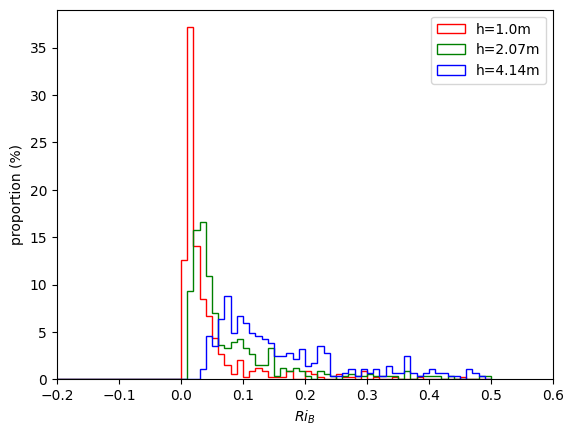

In [33]:
fig=plt.figure()
#plt.title("distribution (normalisée) de $Ri_B$ pour T2_TO5 ")
plt.hist(IRGA_1_moy['Ri'],density=True,bins=100,histtype='step',range=(-0.5,0.5),label='h='+str(IRGA_1_moy['z'])+'m',color='r')
plt.hist(IRGA_2_moy['Ri'],density=True,bins=100,histtype='step',range=(-0.5,0.5),label='h='+str(IRGA_2_moy['z'])+'m',color='g')
plt.hist(IRGA_3_moy['Ri'],density=True,bins=100,histtype='step',range=(-0.5,0.5),label='h='+str(IRGA_3_moy['z'])+'m',color='b')
plt.legend()
plt.xlabel(r"$Ri_B$")
plt.ylabel(r"proportion (%)")
plt.xlim(-0.2,0.6)
plt.savefig(repertoire_figures+"T2_Ri_hist.png")

In [4]:
#Application d'une rotation afin de placer le repère dans le sens du vent d'annuler la vitesse verticale
print("annulation de la vitesse verticale w")
IRGA_1_segments=annulation_w(IRGA_1_segments)
IRGA_2_segments=annulation_w(IRGA_2_segments)
IRGA_3_segments=annulation_w(IRGA_3_segments)
print("fait")

annulation de la vitesse verticale w
fait


In [5]:
date_range=pd.date_range(start=tmin_T2_TO5,
                         end=tmax_T2_TO5,freq=duree_segments,inclusive='right').values
print(date_range.size)
index_segments=np.arange(N_ech_segments)

def Ds_cov(Ds):
    Ds_wu=xr.cov(Ds['w'],Ds['u'],dim='index').to_dataset(name='wu_cov')
    Ds_wv=xr.cov(Ds['w'],Ds['v'],dim='index').to_dataset(name='wv_cov')
    Ds_uts=xr.cov(Ds['u'],Ds['Ts'],dim='index').to_dataset(name='uts_cov')
    Ds_wts=xr.cov(Ds['w'],Ds['Ts'],dim='index').to_dataset(name='wts_cov')
    Ds_u_mean=Ds['u'].mean(dim='index').to_dataset(name='u_rot')
    Ds_ts=Ds['Ts'].mean(dim='index').to_dataset(name='ts_mean')
    return xr.merge([Ds_wu,
                     Ds_wv,
                     Ds_wts,
                     Ds_uts,
                     Ds_u_mean,
                     Ds_ts])

Ds_IRGA_1_tps=xr.Dataset(data_vars=dict(u=(('temps','index'),IRGA_1_segments['u']),
                                    v=(('temps','index'),IRGA_1_segments['v']),
                                    w=(('temps','index'),IRGA_1_segments['w']),
                                    Ts=(('temps','index'),IRGA_1_segments['Ts']),
                                    q=(('temps','index'),IRGA_1_segments['q'])),
                     coords={'temps':date_range,'index':index_segments})
Ds_cov_1=Ds_cov(Ds_IRGA_1_tps)
print(Ds_cov_1)
Ds_cov_1.to_netcdf("flux_brut_T2TO5_1.nc")
Ds_IRGA_2_tps=xr.Dataset(data_vars=dict(u=(('temps','index'),IRGA_2_segments['u']),
                                    v=(('temps','index'),IRGA_2_segments['v']),
                                    w=(('temps','index'),IRGA_2_segments['w']),
                                    Ts=(('temps','index'),IRGA_2_segments['Ts'])),
                     coords={'temps':date_range,'index':index_segments})
Ds_cov_2=Ds_cov(Ds_IRGA_2_tps)
Ds_cov_2.to_netcdf("flux_brut_T2TO5_2.nc")

Ds_IRGA_3_tps=xr.Dataset(data_vars=dict(u=(('temps','index'),IRGA_3_segments['u']),
                                    v=(('temps','index'),IRGA_3_segments['v']),
                                    w=(('temps','index'),IRGA_3_segments['w']),
                                    Ts=(('temps','index'),IRGA_3_segments['Ts'])),
                     coords={'temps':date_range,'index':index_segments})
Ds_cov_3=Ds_cov(Ds_IRGA_3_tps)
Ds_cov_3.to_netcdf("flux_brut_T2TO5_3.nc")
print(xr.cov(Ds_IRGA_1_tps['w'],Ds_IRGA_1_tps['u'],dim='index'))

360
<xarray.Dataset>
Dimensions:  (temps: 360)
Coordinates:
  * temps    (temps) datetime64[ns] 2023-09-01T00:30:00 ... 2023-09-08T12:00:00
Data variables:
    wu_cov   (temps) float64 -0.005414 -0.08145 0.005398 ... -0.01058 -0.0268
    wv_cov   (temps) float64 -0.1436 0.4233 -0.08009 ... 0.0003964 0.007187
    wts_cov  (temps) float64 -0.03637 -0.05489 -0.01997 ... -0.01048 -0.02909
    uts_cov  (temps) float64 0.04676 0.2573 -0.02532 ... -0.0323 -0.887 -0.4442
    u_rot    (temps) float64 -3.252 3.366 -1.37 -1.417 ... 3.889 2.933 3.588
    ts_mean  (temps) float64 278.3 278.7 278.7 278.4 ... 281.2 281.8 282.9 283.0
<xarray.DataArray (temps: 360)>
array([-5.41395935e-03, -8.14462365e-02,  5.39782595e-03,  3.80522106e-02,
       -1.55226956e-01, -1.32180648e-01, -1.61807576e-02, -1.06860887e-02,
       -2.41185871e-02,  4.61593375e-03,  9.00648203e-03, -3.74734674e-02,
       -1.17556926e-02,  1.23413005e-02, -3.03406120e-02, -5.28686510e-02,
       -4.36222119e-02, -4.72126673e-02, -

In [6]:
index_segments=np.arange(N_ech_segments)
Ri_min=0.0
Ri_max=0.3
#on prend Ri entre la surface et le niveau le plus bas
Ds_IRGA_1=xr.Dataset(data_vars=dict(u=(('Ri','index'),IRGA_1_segments['u']),
                                    v=(('Ri','index'),IRGA_1_segments['v']),
                                    w=(('Ri','index'),IRGA_1_segments['w']),
                                    Ts=(('Ri','index'),IRGA_1_segments['Ts']),
                                    q=(('Ri','index'),IRGA_1_segments['q'])),
                     coords={'Ri':IRGA_1_moy['Ri'],'index':index_segments}).sortby('Ri').sel(Ri=slice(Ri_min,Ri_max))
Ds_IRGA_2=xr.Dataset(data_vars=dict(u=(('Ri','index'),IRGA_2_segments['u']),
                                    v=(('Ri','index'),IRGA_2_segments['v']),
                                    w=(('Ri','index'),IRGA_2_segments['w']),
                                    Ts=(('Ri','index'),IRGA_2_segments['Ts'])),
                     coords={'Ri':IRGA_1_moy['Ri'],'index':index_segments}).sortby('Ri').sel(Ri=slice(Ri_min,Ri_max))
Ds_IRGA_3=xr.Dataset(data_vars=dict(u=(('Ri','index'),IRGA_3_segments['u']),
                                    v=(('Ri','index'),IRGA_3_segments['v']),
                                    w=(('Ri','index'),IRGA_3_segments['w']),
                                    Ts=(('Ri','index'),IRGA_3_segments['Ts'])),
                     coords={'Ri':IRGA_1_moy['Ri'],'index':index_segments}).sortby('Ri').sel(Ri=slice(Ri_min,Ri_max))
print(Ds_IRGA_1)

<xarray.Dataset>
Dimensions:  (Ri: 338, index: 36000)
Coordinates:
  * Ri       (Ri) float64 0.006014 0.006168 0.006954 ... 0.2921 0.2941 0.2945
  * index    (index) int32 0 1 2 3 4 5 6 ... 35994 35995 35996 35997 35998 35999
Data variables:
    u        (Ri, index) float64 5.423 5.912 6.313 6.045 ... 1.008 1.016 1.017
    v        (Ri, index) float64 -0.1211 -0.1652 -0.3089 ... -0.1985 -0.1214
    w        (Ri, index) float64 0.2488 -0.0885 -0.1729 ... 0.03073 0.009063
    Ts       (Ri, index) float64 279.0 279.4 280.4 280.0 ... 285.0 284.9 285.2
    q        (Ri, index) float64 2.362 2.374 2.127 2.087 ... 3.372 3.386 3.365


In [7]:
print(np.mean(Ds_IRGA_1.isel(Ri=0)['u'].values))
print(np.mean(Ds_IRGA_1.isel(Ri=0)['v'].values))
print(np.mean(Ds_IRGA_1.isel(Ri=0)['w'].values))

6.134639649510915
-4.105358028836134e-17
-9.888386405994728e-17


In [8]:
Ds_test=xr.Dataset(data_vars={'w':(("d",'index'),[np.array([1,3,2,5,1,2,1,3]),np.array([1,3,2,5,1,2,1,3])]),
                              'p':(("d",'index'),[np.array([1,5,3,2,5,4,3,2]),np.array([1,5,3,2,5,4,3,2])])},
                 coords={"temps":np.arange(2),'index':np.arange(8)})
def MRD_Ds(Ds,var=('x','y'),axis='Ri',freq_ech=20.0,**kwargs):
    #idem que MRD_segments, mais pour un Dataset xarray 1D
    #ajoute une dimension "temps"
    #fiable, car conserve l'ordre des segments
    nb_segments=Ds.coords[axis].values.size
    nb_ech_segments=Ds.coords['index'].values.size
    temps_MRD=MRD.echelles_temps_MSB(nb_ech_segments,freq_ech)
    #coords=xr.Coordinates(coords={axis:Ds.coords[axis].values,'temps':temps})
    liste_Ds=[]
    #print(temps_MRD)
    #print(Ds.coords[axis].values)
    #print(Ds.coords['index'].values)
    for i in tqdm(range(0,nb_segments)):
        #print(Ds.coords[axis].values[i])
        res_MRD_i=MRD.MRD(Ds[var[0]].values[i],Ds[var[1]].values[i],name=(var[0],var[1]),get_timescale=False,**kwargs)
        #print({key:(('temps',axis),res_MRD_i[key]) for key in res_MRD_i.keys()})
        Ds_i=xr.Dataset(data_vars={key:('temps',res_MRD_i[key]) for key in res_MRD_i.keys()},
                        coords={'temps':temps_MRD}).expand_dims({axis:[Ds[axis].values[i]]})
        liste_Ds.append(Ds_i)
    return xr.concat(liste_Ds,dim=axis)

print(Ds_test)
print(MRD_Ds(Ds_test,var=('w','p'),axis='d',freq_ech=1))

<xarray.Dataset>
Dimensions:  (d: 2, index: 8, temps: 2)
Coordinates:
  * temps    (temps) int32 0 1
  * index    (index) int32 0 1 2 3 4 5 6 7
Dimensions without coordinates: d
Data variables:
    w        (d, index) int32 1 3 2 5 1 2 1 3 1 3 2 5 1 2 1 3
    p        (d, index) int32 1 5 3 2 5 4 3 2 1 5 3 2 5 4 3 2


  0%|          | 0/2 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:  (d: 2, temps: 3)
Coordinates:
  * d        (d) int64 0 1
  * temps    (temps) float64 1.0 2.0 4.0
Data variables:
    wp       (d, temps) float64 0.125 -0.2188 -0.1875 0.125 -0.2188 -0.1875
    wp_cum   (d, temps) float64 0.125 -0.09375 -0.2812 0.125 -0.09375 -0.2812
    w        (d, temps) float64 1.125 0.3125 0.25 1.125 0.3125 0.25
    w_cum    (d, temps) float64 1.125 1.438 1.688 1.125 1.438 1.688
    p        (d, temps) float64 1.188 0.5312 0.1406 1.188 0.5312 0.1406
    p_cum    (d, temps) float64 1.188 1.719 1.859 1.188 1.719 1.859


In [9]:
#calcul des spectres MRD

print("calcul des MRD pour flux de chaleur (wT)")
print("niveau 1")
MRD_wTs_IRGA_1=MRD_Ds(Ds_IRGA_1,var=('w','Ts'),axis='Ri',freq_ech=20.0)
print("niveau 2")
MRD_wTs_IRGA_2=MRD_Ds(Ds_IRGA_2,var=('w','Ts'),axis='Ri',freq_ech=20.0)
print("niveau 3")
MRD_wTs_IRGA_3=MRD_Ds(Ds_IRGA_3,var=('w','Ts'),axis='Ri',freq_ech=20.0)
print("calcul des MRD pour flux de QDM (uw)")
print("niveau 1")
MRD_uw_IRGA_1=MRD_Ds(Ds_IRGA_1,var=('u','w'),axis='Ri',freq_ech=20.0)
print("niveau 2")
MRD_uw_IRGA_2=MRD_Ds(Ds_IRGA_2,var=('u','w'),axis='Ri',freq_ech=20.0)
print("niveau 3")
MRD_uw_IRGA_3=MRD_Ds(Ds_IRGA_3,var=('u','w'),axis='Ri',freq_ech=20.0)

print("calcul des MRD pour flux de QDM (vw)")
print("niveau 1")
MRD_vw_IRGA_1=MRD_Ds(Ds_IRGA_1,var=('v','w'),axis='Ri',freq_ech=20.0)
print("niveau 2")
MRD_vw_IRGA_2=MRD_Ds(Ds_IRGA_2,var=('v','w'),axis='Ri',freq_ech=20.0)
print("niveau 3")
MRD_vw_IRGA_3=MRD_Ds(Ds_IRGA_3,var=('v','w'),axis='Ri',freq_ech=20.0)

print("calcul des MRD pour flux d'humidité (niveau 1 seulement)")
MRD_wq_IRGA_1=MRD_Ds(Ds_IRGA_1,var=('w','q'),axis='Ri',freq_ech=20.0)

calcul des MRD pour flux de chaleur (wT)
niveau 1


  0%|          | 0/338 [00:00<?, ?it/s]

niveau 2


  0%|          | 0/338 [00:00<?, ?it/s]

niveau 3


  0%|          | 0/338 [00:00<?, ?it/s]

calcul des MRD pour flux de QDM (uw)
niveau 1


  0%|          | 0/338 [00:00<?, ?it/s]

niveau 2


  0%|          | 0/338 [00:00<?, ?it/s]

niveau 3


  0%|          | 0/338 [00:00<?, ?it/s]

calcul des MRD pour flux de QDM (vw)
niveau 1


  0%|          | 0/338 [00:00<?, ?it/s]

niveau 2


  0%|          | 0/338 [00:00<?, ?it/s]

niveau 3


  0%|          | 0/338 [00:00<?, ?it/s]

calcul des MRD pour flux d'humidité (niveau 1 seulement)


  0%|          | 0/338 [00:00<?, ?it/s]

In [10]:
print("calcul des MRD pour flux de QDM (uv)")
print("niveau 1")
MRD_uv_IRGA_1=MRD_Ds(Ds_IRGA_1,var=('u','v'),axis='Ri',freq_ech=20.0, get_spectres=False)
print("niveau 2")
MRD_uv_IRGA_2=MRD_Ds(Ds_IRGA_2,var=('u','v'),axis='Ri',freq_ech=20.0, get_spectres=False)
print("niveau 3")
MRD_uv_IRGA_3=MRD_Ds(Ds_IRGA_3,var=('u','v'),axis='Ri',freq_ech=20.0, get_spectres=False)


print("calcul des MRD pour flux de chaleur horizontal (uT)")
print("niveau 1")
MRD_uT_IRGA_1=MRD_Ds(Ds_IRGA_1,var=('u','Ts'),axis='Ri',freq_ech=20.0, get_spectres=False)
print("niveau 2")
MRD_uT_IRGA_2=MRD_Ds(Ds_IRGA_2,var=('u','Ts'),axis='Ri',freq_ech=20.0, get_spectres=False)
print("niveau 3")
MRD_uT_IRGA_3=MRD_Ds(Ds_IRGA_3,var=('u','Ts'),axis='Ri',freq_ech=20.0, get_spectres=False)

calcul des MRD pour flux de QDM (uv)
niveau 1


  0%|          | 0/338 [00:00<?, ?it/s]

niveau 2


  0%|          | 0/338 [00:00<?, ?it/s]

niveau 3


  0%|          | 0/338 [00:00<?, ?it/s]

calcul des MRD pour flux de chaleur horizontal (uT)
niveau 1


  0%|          | 0/338 [00:00<?, ?it/s]

niveau 2


  0%|          | 0/338 [00:00<?, ?it/s]

niveau 3


  0%|          | 0/338 [00:00<?, ?it/s]

In [11]:
import scipy
def gap_spectral_algo(spectre,spectre_sum,index,seuil=0.01,amplitude_pic=0.2,t_min=400):
    "retourne le gap spectral et le premier pic (associé à la turbulence)"
    #algorithme basé sur celui présenté dans Vickers and Mahrt 2003.
    #le pic associé à la turbulence est supposé être le plus fort en amplitude
    #le gap spectral est obtenu lorsqu'après avoir atteint le pic associé à la turbulence, le spectre cumulé varie
    # de moins de 1%
    #res_MRD : dictionnaire contenant le spectre et le spectre cumulé,var:variable à traiter, index : échelles de temps
    #Je garantis pas que ça donnera des résultats systématiquement cohérents
    gap=0.0
    spectre_copy=np.copy(spectre)
    #print(f"spectre_copy {spectre_copy}")
    spectre_sum_copy=np.copy(spectre_sum)
    arg_pics,caracteristiques=scipy.signal.find_peaks(np.abs(spectre),prominence=amplitude_pic*np.abs(spectre).max())
    if arg_pics.size==0: return np.NaN,np.NaN
    arg_pic_spectre=arg_pics[0]
    #print(index[arg_pic_spectre])
    if index[arg_pic_spectre] > t_min:return np.NaN,np.NaN
    pic=index[arg_pic_spectre]
    pic=np.around(index[arg_pic_spectre],3)
    gap=0.0
    #iterateur=range(arg_pic,len(spectre_copy))
    for i in range(arg_pic_spectre,len(spectre_copy)):
        #delta_spectre_sum=(spectre_sum[i+1]-spectre_sum[i-1])/2.0#shéma centré
        #delta_spectre_sum=(spectre_sum[i+1]-spectre_sum[i])#shéma vers la droite
        delta_spectre_sum=(spectre_sum[i]-spectre_sum[i-1])#shéma vers la gauche
        if (np.abs(delta_spectre_sum/spectre_sum[i]) <= seuil):
            gap=index[i]
            return pic,np.around(gap,3)
    return pic,np.NaN

def signe_pic(array):
    "détermine le signe du plus grand pic d'un spectre"
    min_array = np.min(array)
    max_array = np.max(array)
    return -1 if (np.abs(min_array) > np.abs(max_array)) else 1


In [12]:
#calcul du gap spectral (avec algorithme présenté dans Vickers and Mahrt 2003)
import MRD as MRD_v1
def gap_spectral_Ds(Ds_MRD,axis,**kwargs):
    coord=Ds_MRD.coords[axis].values
    #print(coord)
    liste_vars=Ds_MRD.data_vars
    #liste_Ds_pic=[]
    #liste_Ds_gap=[]
    liste_Ds=[]
    for i in range(0,coord.size):
        liste_Ds_vars=[]
        for vars in liste_vars:
            if '_cum'  not in vars:
                """
                pic,gap=MRD.gap_spectral_algo(Ds_MRD[vars].isel({axis:i}).values,
                                              Ds_MRD[vars+'_cum'].isel({axis:i}).values,
                                              Ds_MRD.coords['temps'].values,**kwargs)"""
                pic,gap=gap_spectral_algo(Ds_MRD[vars].isel({axis:i}).values,
                                              Ds_MRD[vars+'_cum'].isel({axis:i}).values,
                                              Ds_MRD.coords['temps'].values,**kwargs)
                """
                gap,pic=MRD_v1.gap_spectral(Ds_MRD[vars].isel({axis:i}).values,
                                              Ds_MRD[vars+'_cum'].isel({axis:i}).values,
                                              Ds_MRD.coords['temps'].values,**kwargs)
                """
                Ds_var=xr.Dataset({vars+'_pic':(axis,[pic]),vars+'_gap':(axis,[gap])},
                                   coords={axis:[coord[i]]})
                liste_Ds_vars.append(Ds_var)
        liste_Ds.append(xr.merge(liste_Ds_vars))
    return xr.concat(liste_Ds,axis)
print(gap_spectral_Ds(MRD_wTs_IRGA_1,'Ri'))

<xarray.Dataset>
Dimensions:  (Ri: 338)
Coordinates:
  * Ri       (Ri) float64 0.006014 0.006168 0.006954 ... 0.2921 0.2941 0.2945
Data variables:
    wTs_pic  (Ri) float64 nan nan nan nan nan nan ... 1.6 6.4 1.6 1.6 3.2 3.2
    wTs_gap  (Ri) float64 nan nan nan nan nan ... 204.8 nan 204.8 102.4 409.6
    w_pic    (Ri) float64 nan nan nan nan nan nan ... 0.8 0.8 nan 1.6 1.6 1.6
    w_gap    (Ri) float64 nan nan nan nan nan ... 102.4 nan 819.2 204.8 409.6
    Ts_pic   (Ri) float64 nan 204.8 12.8 nan 12.8 nan ... 12.8 12.8 12.8 nan 3.2
    Ts_gap   (Ri) float64 nan 819.2 819.2 nan nan ... nan nan 819.2 nan 409.6


In [13]:
pas_Ri=0.15
bins_Ri=np.arange(Ri_min,Ri_max+pas_Ri,pas_Ri)
#print(bins_Ri)
#print(MRD_wTs_IRGA_1)
Ds_group=MRD_wTs_IRGA_1.groupby_bins('Ri',bins_Ri,squeeze=False)
print(len(Ds_group.groups))
print("toto")
"""
for groups in Ds_group.groups:
    print(f"group_moy {groups.mid}")
    print(f"Ds_group[group] {Ds_group[groups]}")
print(f"Ds_group[group] {Ds_group.mean('Ri')['wTs']}")

"""

2
toto


'\nfor groups in Ds_group.groups:\n    print(f"group_moy {groups.mid}")\n    print(f"Ds_group[group] {Ds_group[groups]}")\nprint(f"Ds_group[group] {Ds_group.mean(\'Ri\')[\'wTs\']}")\n\n'

In [14]:
repertoire_figures=repertoire_courant+r"\\"+r"figures"+r"\\"

<>:69: SyntaxWarning: invalid escape sequence '\c'
<>:90: SyntaxWarning: invalid escape sequence '\c'
<>:111: SyntaxWarning: invalid escape sequence '\c'
<>:69: SyntaxWarning: invalid escape sequence '\c'
<>:90: SyntaxWarning: invalid escape sequence '\c'
<>:111: SyntaxWarning: invalid escape sequence '\c'
C:\Users\evanl\AppData\Local\Temp\ipykernel_35708\2065712946.py:69: SyntaxWarning: invalid escape sequence '\c'
  """
C:\Users\evanl\AppData\Local\Temp\ipykernel_35708\2065712946.py:90: SyntaxWarning: invalid escape sequence '\c'
  """
C:\Users\evanl\AppData\Local\Temp\ipykernel_35708\2065712946.py:111: SyntaxWarning: invalid escape sequence '\c'
  """


'\nfig=plt.figure()\nplt.title("flux z = "+str(IRGA_3_segments[\'z\'])+" m")\nplot_MRD_bins(wTs_3_bins,\'wTs_cum\',\'Ri\')\nplt.xscale(\'log\')\nplt.legend()\nplt.xlabel("temps (s)")\nplt.ylabel(r"flux $K\\cdot m \\cdot s^{-1}$")\n'

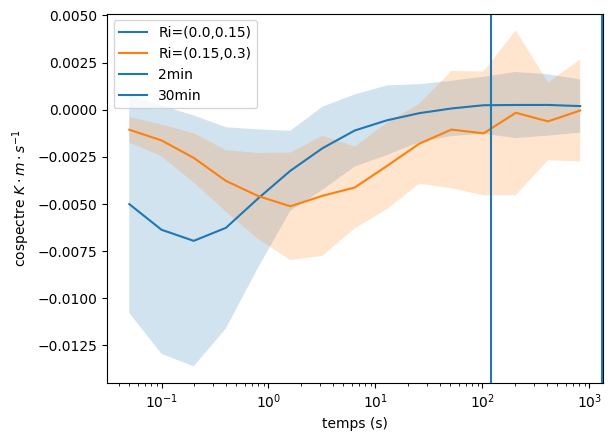

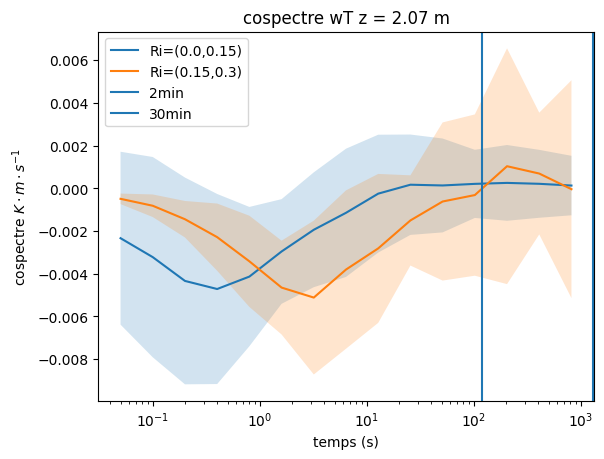

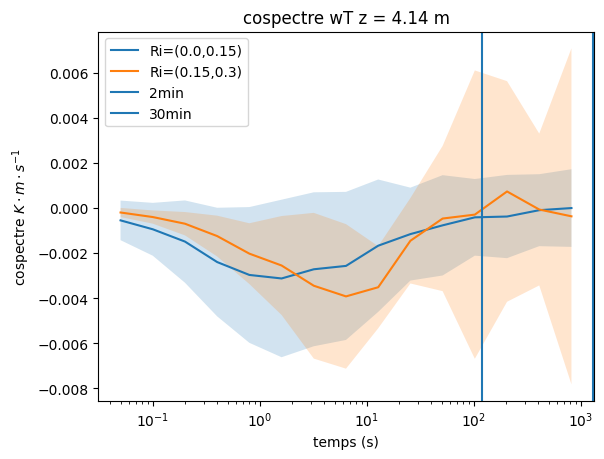

In [15]:
#spectre MRD wTs pour les trois niveaux
wTs_1_bins=MRD_wTs_IRGA_1.groupby_bins('Ri',bins_Ri,squeeze=True)
wTs_2_bins=MRD_wTs_IRGA_2.groupby_bins('Ri',bins_Ri,squeeze=True)
wTs_3_bins=MRD_wTs_IRGA_3.groupby_bins('Ri',bins_Ri,squeeze=True)
#pics et gap spectraux
wTs_1_gap=gap_spectral_Ds(MRD_wTs_IRGA_1,'Ri').groupby_bins('Ri',bins_Ri,squeeze=True)#.mean('Ri')
wTs_2_gap=gap_spectral_Ds(MRD_wTs_IRGA_2,'Ri').groupby_bins('Ri',bins_Ri,squeeze=True)#.mean('Ri')
wTs_3_gap=gap_spectral_Ds(MRD_wTs_IRGA_3,'Ri').groupby_bins('Ri',bins_Ri,squeeze=True)#.mean('Ri')


def plot_MRD_bins(Ds_binned, var,axis,**kwargs):
    for groups in Ds_binned.groups:
        Ds_i=Ds_binned[groups]
        #Ds_moy=Ds_i[var].mean(axis).values
        Ds_moy=Ds_i[var].median(axis).values
        #Ds_std=Ds_i[var].std(axis).values
        Ds_std=Ds_i[var].quantile(0.75,axis).values-Ds_i[var].quantile(0.25,axis).values
        """
        plt.errorbar(Ds_i.coords['temps'].values,
                     Ds_moy,yerr=Ds_std,label=axis+'=('+str(groups.left)+','+str(groups.right)+')',**kwargs)"""
        plt.plot(Ds_i.coords['temps'].values,Ds_moy,label=axis+'=('+str(groups.left)+','+str(groups.right)+')')
        #                                                              type pandas.interval
        plt.fill_between(Ds_i.coords['temps'].values,Ds_moy-Ds_std,Ds_moy+Ds_std,alpha=0.2)

def plot_MRD_bins_ax(Ds_binned, var,axis,**kwargs):
    for groups in Ds_binned.groups:
        Ds_i=Ds_binned[groups]
        Ds_moy=Ds_i[var].mean(axis).values
        Ds_std=Ds_i[var].std(axis).values
        """
        plt.errorbar(Ds_i.coords['temps'].values,
                     Ds_moy,yerr=Ds_std,label=axis+'=('+str(groups.left)+','+str(groups.right)+')',**kwargs)"""
        ax.plot(Ds_i.coords['temps'].values,Ds_moy,label=axis+'=('+str(groups.left)+','+str(groups.right)+')')
        #                                                              type pandas.interval
        ax.fill_between(Ds_i.coords['temps'].values,Ds_moy-Ds_std,Ds_moy+Ds_std,alpha=0.2)
def plot_MRD_bins_gap(Ds_binned,Ds_binned_gap, var,axis,**kwargs):
    for groups in Ds_binned.groups:
        Ds_i=Ds_binned[groups]
        Ds_moy=Ds_i[var].mean(axis).values
        Ds_moy_cum=Ds_i[var+'_cum'].mean(axis).values
        Ds_std=Ds_i[var].std(axis).values
        """
        plt.errorbar(Ds_i.coords['temps'].values,
                     Ds_moy,yerr=Ds_std,label=axis+'=('+str(groups.left)+','+str(groups.right)+')',**kwargs)"""
        plt.plot(Ds_i.coords['temps'].values,Ds_moy,label=axis+'=('+str(groups.left)+','+str(groups.right)+')')
        plt.fill_between(Ds_i.coords['temps'].values,Ds_moy-Ds_std,Ds_moy+Ds_std,alpha=0.2)
        Ds_gap_i=Ds_binned_gap[groups].mean('Ri')
        pic_i=Ds_gap_i[var+'_pic'].values
        gap_i=Ds_gap_i[var+'_gap'].values
        #pic_i,gap_i=gap_spectral_algo(Ds_moy,Ds_moy_cum,Ds_i.coords['temps'].values)
        #gap_i,pic_i=MRD_v1.gap_spectral(Ds_moy,Ds_moy_cum,Ds_i.coords['temps'].values)
        #gap_i=Ds_gap_i[var+'_gap'].values
        #pic_i=Ds_gap_i[var+'_pic'].values
        print(pic_i)
        plt.axvline(x=pic_i,label='pic = '+str(pic_i)+" s",linestyle='-.')
        plt.axvline(x=gap_i,label='gap = '+str(gap_i)+" s",linestyle=':')

fig=plt.figure()
#plt.title("cospectre wT z = "+str(IRGA_1_segments['z'])+" m")
plot_MRD_bins(wTs_1_bins,'wTs','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $K\cdot m \cdot s^{-1}$")
plt.savefig(repertoire_figures+"MRD_wT_1_bins.png")
"""
fig=plt.figure()
plt.title("flux z = "+str(IRGA_1_segments['z'])+" m")
plot_MRD_bins(wTs_1_bins,'wTs_cum','Ri')
plt.xscale('log')
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"flux $K\cdot m \cdot s^{-1}$")
"""

fig=plt.figure()
plt.title("cospectre wT z = "+str(IRGA_2_segments['z'])+" m")
plot_MRD_bins(wTs_2_bins,'wTs','Ri')
#plot_MRD_bins_gap(wTs_2_bins,wTs_2_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $K\cdot m \cdot s^{-1}$")
#plt.savefig(repertoire_figures+"MRD_wT_2_bins.png")
"""
fig=plt.figure()
plt.title("flux z = "+str(IRGA_2_segments['z'])+" m")
plot_MRD_bins(wTs_2_bins,'wTs_cum','Ri')
plt.xscale('log')
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"flux $K\cdot m \cdot s^{-1}$")
"""

fig=plt.figure()
plt.title("cospectre wT z = "+str(IRGA_3_segments['z'])+" m")
#plot_MRD_bins_gap(wTs_3_bins,wTs_3_gap,'wTs','Ri')
plot_MRD_bins(wTs_3_bins,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $K\cdot m \cdot s^{-1}$")
#plt.savefig(repertoire_figures+"MRD_wT_3_bins.png")
"""
fig=plt.figure()
plt.title("flux z = "+str(IRGA_3_segments['z'])+" m")
plot_MRD_bins(wTs_3_bins,'wTs_cum','Ri')
plt.xscale('log')
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"flux $K\cdot m \cdot s^{-1}$")
"""

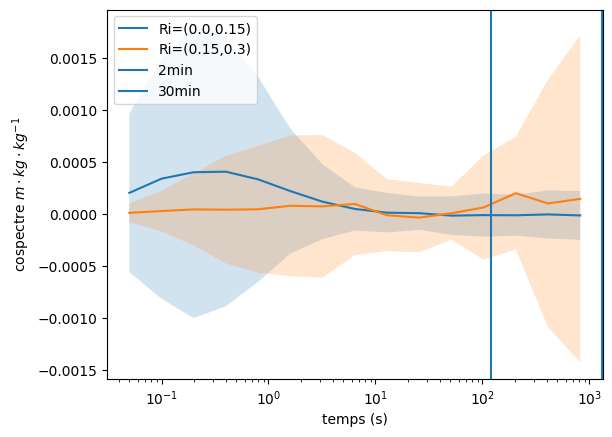

In [16]:
wq_1_bins=MRD_wq_IRGA_1.groupby_bins('Ri',bins_Ri,squeeze=True)
fig=plt.figure()
#plt.title("cospectre wq z = "+str(IRGA_1_segments['z'])+" m")
plot_MRD_bins(wq_1_bins,'wq','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m \cdot kg\cdot kg^{-1}$")

plt.savefig(repertoire_figures+"MRD_wq_bins.png")

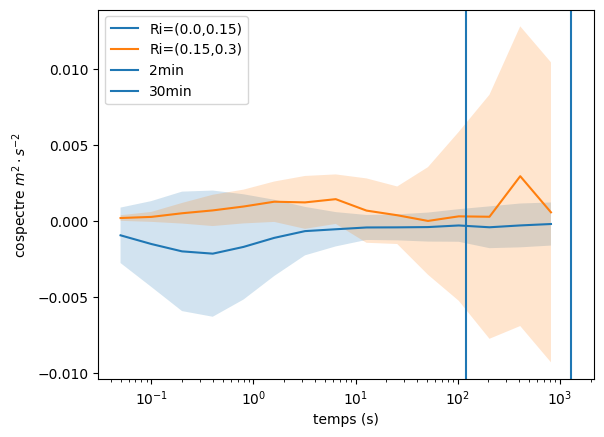

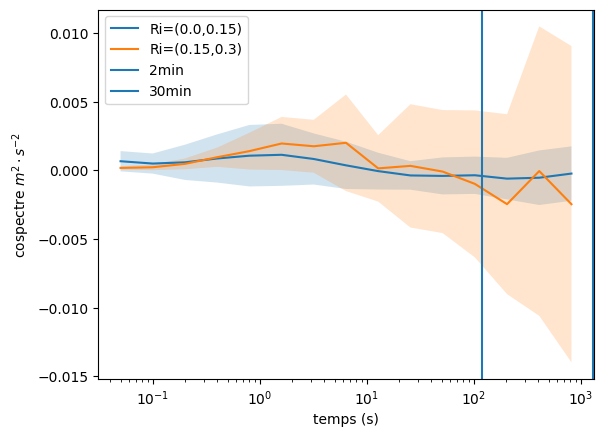

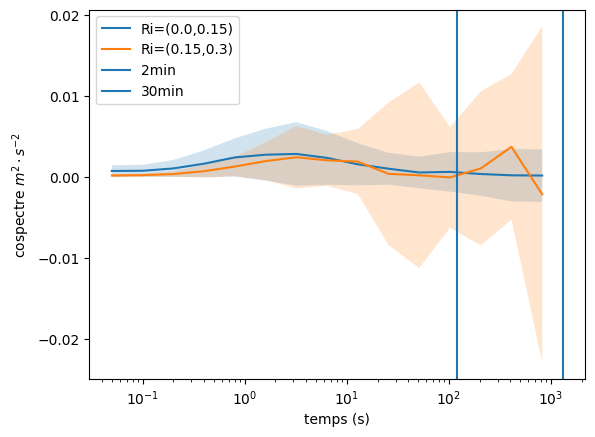

In [17]:
uw_1_bins=MRD_uw_IRGA_1.groupby_bins('Ri',bins_Ri,squeeze=True)
uw_2_bins=MRD_uw_IRGA_2.groupby_bins('Ri',bins_Ri,squeeze=True)
uw_3_bins=MRD_uw_IRGA_3.groupby_bins('Ri',bins_Ri,squeeze=True)


fig=plt.figure()
#plt.title("cospectre uw z = "+str(IRGA_1_segments['z'])+" m")
plot_MRD_bins(uw_1_bins,'uw','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.xscale('log')
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
plt.savefig(repertoire_figures+"MRD_uw_1_bins.png")

fig=plt.figure()
#plt.title("cospectre uw z = "+str(IRGA_2_segments['z'])+" m")
plot_MRD_bins(uw_2_bins,'uw','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
plt.savefig(repertoire_figures+"MRD_uw_2_bins.png")

fig=plt.figure()
#plt.title("cospectre uw z = "+str(IRGA_3_segments['z'])+" m")
plot_MRD_bins(uw_3_bins,'uw','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.xscale('log')
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
plt.savefig(repertoire_figures+"MRD_uw_3_bins.png")

In [18]:
df=pd.DataFrame(dict(variable=['wT','uw','vw','wq'],
                     detection_pic=['45','56','67','56']))
print(df)

  variable detection_pic
0       wT            45
1       uw            56
2       vw            67
3       wq            56


In [19]:
a=np.array([i for i in range(0,10)])
print(np.where(a < 5,True,False))

[ True  True  True  True  True False False False False False]


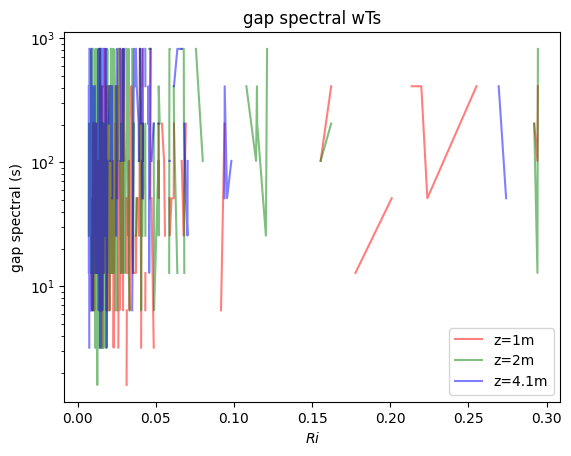

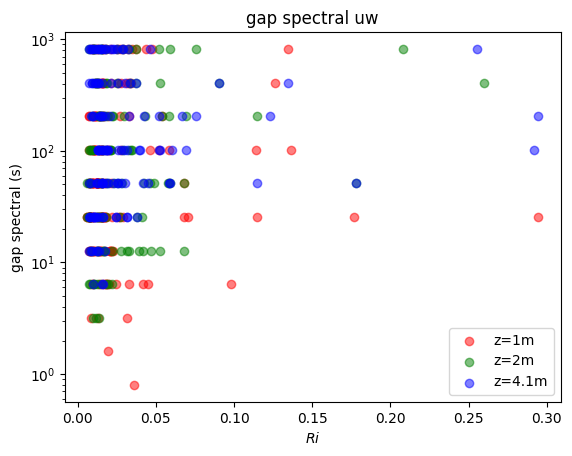

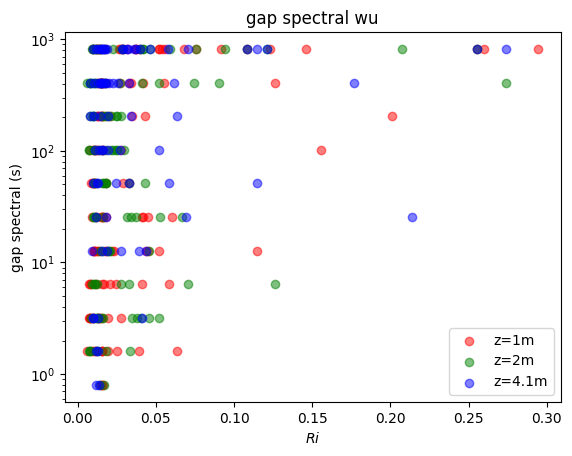

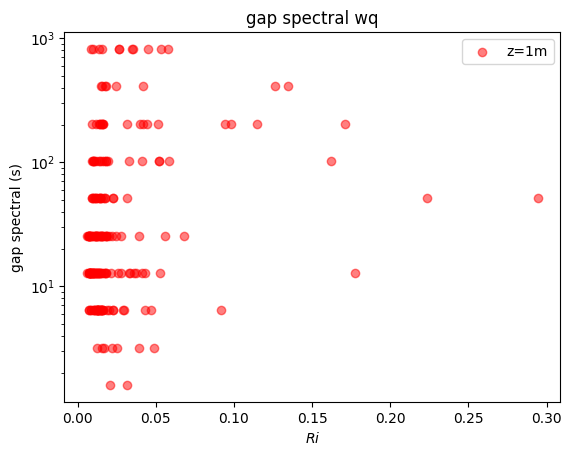

In [20]:
gap_wTs_1=gap_spectral_Ds(MRD_wTs_IRGA_1,'Ri')
gap_wTs_2=gap_spectral_Ds(MRD_wTs_IRGA_2,'Ri')
gap_wTs_3=gap_spectral_Ds(MRD_wTs_IRGA_3,'Ri')
gap_wq=gap_spectral_Ds(MRD_wq_IRGA_1,'Ri')

gap_uw_1=gap_spectral_Ds(MRD_uw_IRGA_1,'Ri')
gap_uw_2=gap_spectral_Ds(MRD_uw_IRGA_2,'Ri')
gap_uw_3=gap_spectral_Ds(MRD_uw_IRGA_3,'Ri')

gap_vw_1=gap_spectral_Ds(MRD_vw_IRGA_1,'Ri')
gap_vw_2=gap_spectral_Ds(MRD_vw_IRGA_2,'Ri')
gap_vw_3=gap_spectral_Ds(MRD_vw_IRGA_3,'Ri')

fig=plt.figure()
plt.title('gap spectral wTs')
plt.plot(gap_wTs_1.coords['Ri'].values,gap_wTs_1['wTs_gap'].values,label='z=1m',color='r',alpha=0.5)
plt.plot(gap_wTs_2.coords['Ri'].values,gap_wTs_2['wTs_gap'].values,label='z=2m',color='g',alpha=0.5)
plt.plot(gap_wTs_3.coords['Ri'].values,gap_wTs_3['wTs_gap'].values,label='z=4.1m',color='b',alpha=0.5)
plt.legend()
plt.xlabel(r"$Ri$")
plt.ylabel("gap spectral (s)")
plt.yscale('log')

fig=plt.figure()
plt.title('gap spectral uw')
plt.scatter(gap_uw_1.coords['Ri'].values,gap_uw_1['uw_gap'].values,label='z=1m',color='r',alpha=0.5)
plt.scatter(gap_uw_2.coords['Ri'].values,gap_uw_2['uw_gap'].values,label='z=2m',color='g',alpha=0.5)
plt.scatter(gap_uw_3.coords['Ri'].values,gap_uw_3['uw_gap'].values,label='z=4.1m',color='b',alpha=0.5)
plt.legend()
plt.xlabel(r"$Ri$")
plt.ylabel("gap spectral (s)")
plt.yscale('log')

fig=plt.figure()
plt.title('gap spectral wu')
plt.scatter(gap_vw_1.coords['Ri'].values,gap_vw_1['vw_gap'].values,label='z=1m',color='r',alpha=0.5)
plt.scatter(gap_vw_2.coords['Ri'].values,gap_vw_2['vw_gap'].values,label='z=2m',color='g',alpha=0.5)
plt.scatter(gap_vw_3.coords['Ri'].values,gap_vw_3['vw_gap'].values,label='z=4.1m',color='b',alpha=0.5)
plt.legend()
plt.xlabel(r"$Ri$")
plt.ylabel("gap spectral (s)")
plt.yscale('log')

fig=plt.figure()
plt.title('gap spectral wq')
plt.scatter(gap_wq.coords['Ri'].values,gap_wq['wq_gap'].values,label='z=1m',color='r',alpha=0.5)
plt.legend()
plt.xlabel(r"$Ri$")
plt.ylabel("gap spectral (s)")
plt.yscale('log')

niveau 1
variable wTs
taux de detection pic : 79 sur 338
taux de detection gap : 144 sur 338
variable uw
taux de detection pic : 39 sur 338
taux de detection gap : 140 sur 338
variable vw
taux de detection pic : 85 sur 338
taux de detection gap : 203 sur 338
variable wq
taux de detection pic : 45 sur 338
taux de detection gap : 126 sur 338
niveau 2
variable wTs
taux de detection pic : 20 sur 338
taux de detection gap : 105 sur 338
variable uw
taux de detection pic : 38 sur 338
taux de detection gap : 204 sur 338
variable vw
taux de detection pic : 40 sur 338
taux de detection gap : 219 sur 338
niveau 3
variable wTs
taux de detection pic : 4 sur 338
taux de detection gap : 143 sur 338
variable uw
taux de detection pic : 29 sur 338
taux de detection gap : 210 sur 338
variable vw
taux de detection pic : 46 sur 338
taux de detection gap : 259 sur 338
DatasetGroupBy, grouped over 'Ri_bins'
3 groups with labels (0.0,, 0.1], ..., (0.2,, 0.3].


Text(0, 0.5, 'gap spectral(s)')

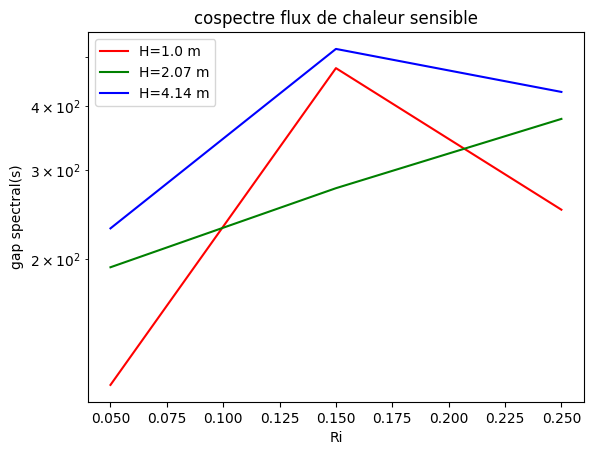

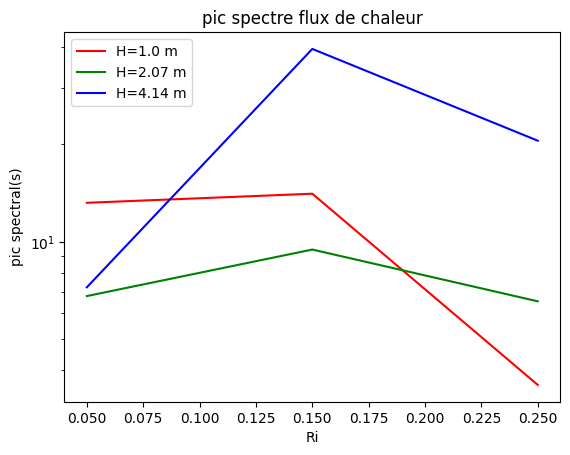

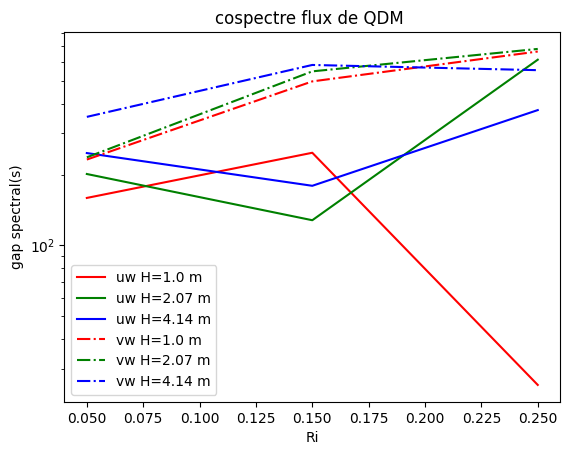

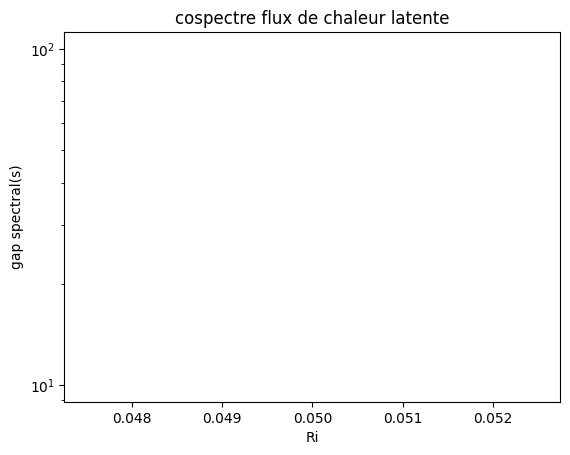

In [21]:
new_pas_Ri=0.1
new_bins_Ri=np.arange(0.0,0.3+new_pas_Ri,new_pas_Ri)

wTs_1_gap=gap_wTs_1.sel(Ri=slice(0.0,0.3)).groupby_bins('Ri',new_bins_Ri,squeeze=True)
wTs_2_gap=gap_wTs_2.sel(Ri=slice(0.0,0.3)).groupby_bins('Ri',new_bins_Ri,squeeze=True)
wTs_3_gap=gap_wTs_3.sel(Ri=slice(0.0,0.3)).groupby_bins('Ri',new_bins_Ri,squeeze=True)

uw_1_gap=gap_uw_1.sel(Ri=slice(0.0,0.3)).groupby_bins('Ri',new_bins_Ri,squeeze=True)
uw_2_gap=gap_uw_2.sel(Ri=slice(0.0,0.3)).groupby_bins('Ri',new_bins_Ri,squeeze=True)
uw_3_gap=gap_uw_3.sel(Ri=slice(0.0,0.3)).groupby_bins('Ri',new_bins_Ri,squeeze=True)

vw_1_gap=gap_vw_1.sel(Ri=slice(0.0,0.3)).groupby_bins('Ri',new_bins_Ri,squeeze=True)
vw_2_gap=gap_vw_2.sel(Ri=slice(0.0,0.3)).groupby_bins('Ri',new_bins_Ri,squeeze=True)
vw_3_gap=gap_vw_3.sel(Ri=slice(0.0,0.3)).groupby_bins('Ri',new_bins_Ri,squeeze=True)

wq_gap=gap_wq.sel(Ri=slice(0.0,0.3)).groupby_bins('Ri',new_bins_Ri,squeeze=True)



def taux_detection_algo(Ds,var):
    array_gap=Ds[var+'_gap'].values
    array_pic=Ds[var+'_pic'].values
    N_nan=lambda x:np.sum(np.where(np.isnan(x), 1, 0))
    N_pic=N_nan(array_pic)
    N_gap=N_nan(array_gap)
    print(f"variable {var}")
    print(f"taux de detection pic : {N_pic} sur {array_pic.size}")
    print(f"taux de detection gap : {N_gap} sur {array_gap.size}")
    return N_pic,N_gap

print("niveau 1")
d_pic_1_wT,d_gap_1_wT = taux_detection_algo(gap_wTs_1,'wTs')
d_pic_1_uw,d_gap_1_uw = taux_detection_algo(gap_uw_1,'uw')
d_pic_1_vw,d_gap_1_vw = taux_detection_algo(gap_vw_1,'vw')
d_pic_1_wq,d_gap_1_wq = taux_detection_algo(gap_wq,'wq')

print("niveau 2")
d_pic_2_wT,d_gap_2_wT = taux_detection_algo(gap_wTs_2,'wTs')
d_pic_2_uw,d_gap_2_uw = taux_detection_algo(gap_uw_2,'uw')
d_pic_2_vw,d_gap_2_vw = taux_detection_algo(gap_vw_2,'vw')

print("niveau 3")
d_pic_2_wT,d_gap_3_wT = taux_detection_algo(gap_wTs_3,'wTs')
d_pic_2_uw,d_gap_3_uw = taux_detection_algo(gap_uw_3,'uw')
d_pic_2_vw,d_gap_3_vw = taux_detection_algo(gap_vw_3,'vw')



wq_gap=gap_spectral_Ds(MRD_wq_IRGA_1,'Ri').sel(Ri=slice(0.0,0.1)).groupby_bins('Ri',new_bins_Ri,squeeze=True)
print(wq_gap)

def get_liste_gap_Ri(Ds_binned,var):
    Ds_moy=Ds_binned.mean('Ri')
    Ds_std=Ds_binned.std('Ri')
    liste_Ri=np.array([group.mid for group in Ds_binned.groups])
    return {'pic':Ds_moy[var+'_pic'].values,
            'pic_std':Ds_std[var+'_pic'].values,
            'gap':Ds_moy[var+'_gap'].values,
            'gap_std':Ds_std[var+'_gap'].values,
            'Ri':liste_Ri}

wTs_gap_1=get_liste_gap_Ri(wTs_1_gap,'wTs')
wTs_gap_2=get_liste_gap_Ri(wTs_2_gap,'wTs')
wTs_gap_3=get_liste_gap_Ri(wTs_3_gap,'wTs')

wq_gap_tot=get_liste_gap_Ri(wq_gap,'wq')

uw_gap_1=get_liste_gap_Ri(uw_1_gap,'uw')
uw_gap_2=get_liste_gap_Ri(uw_2_gap,'uw')
uw_gap_3=get_liste_gap_Ri(uw_3_gap,'uw')

vw_gap_1=get_liste_gap_Ri(vw_1_gap,'vw')
vw_gap_2=get_liste_gap_Ri(vw_2_gap,'vw')
vw_gap_3=get_liste_gap_Ri(vw_3_gap,'vw')


Ri_moy=wTs_gap_1['Ri']
Ri_err=new_pas_Ri
fig=plt.figure()
plt.title("cospectre flux de chaleur sensible")
plt.plot(Ri_moy,wTs_gap_1['gap'],
         color='r',label='H='+str(IRGA_1_segments['z'])+" m")

#Ri_moy=wTs_gap_1['Ri']
"""

plt.fill_between(Ri_moy,wTs_gap_1['gap']-wTs_gap_1['gap_std'],
                 wTs_gap_1['gap']+wTs_gap_1['gap_std'],color='r',alpha=0.2)
"""
plt.plot(Ri_moy,wTs_gap_2['gap'],
         color='g',label='H='+str(IRGA_2_segments['z'])+" m")
"""
plt.fill_between(Ri_moy,wTs_gap_2['gap']-wTs_gap_2['gap_std'],
                 wTs_gap_2['gap']+wTs_gap_2['gap_std'],color='g',alpha=0.2)
"""
plt.plot(Ri_moy,wTs_gap_3['gap'],
         color='b',label='H='+str(IRGA_3_segments['z'])+" m")
"""
plt.fill_between(Ri_moy,wTs_gap_3['gap']-wTs_gap_3['gap_std'],
                 wTs_gap_3['gap']+wTs_gap_3['gap_std'],color='b',alpha=0.2)


plt.errorbar(Ri_moy,wTs_gap_1['gap'],yerr=wTs_gap_1['gap_std'],
             linestyle='-.',marker='o',capthick=10,color='r',label='H='+str(IRGA_1_segments['z'])+" m")
plt.errorbar(Ri_moy,wTs_gap_2['gap'],yerr=wTs_gap_2['gap_std'],
             linestyle='-.',marker='o',capthick=10,color='g',label='H='+str(IRGA_2_segments['z'])+" m")
plt.errorbar(Ri_moy,wTs_gap_3['gap'],yerr=wTs_gap_3['gap_std'],
             linestyle='-.',marker='o',capthick=10,color='b',label='H='+str(IRGA_3_segments['z'])+" m")
"""
plt.legend()
plt.yscale('log')
plt.xlabel('Ri')
plt.ylabel('gap spectral(s)')
#plt.savefig(repertoire_figures+"gap_wT_Ri.png")

fig=plt.figure()
plt.title("pic spectre flux de chaleur")
plt.plot(Ri_moy,wTs_gap_1['pic'],
         color='r',label='H='+str(IRGA_1_segments['z'])+" m")
plt.plot(Ri_moy,wTs_gap_2['pic'],
         color='g',label='H='+str(IRGA_2_segments['z'])+" m")
plt.plot(Ri_moy,wTs_gap_3['pic'],
         color='b',label='H='+str(IRGA_3_segments['z'])+" m")

plt.legend()
plt.yscale('log')
plt.xlabel('Ri')
plt.ylabel('pic spectral(s)')


fig=plt.figure()
plt.title("cospectre flux de QDM ")
plt.plot(Ri_moy,uw_gap_1['gap'],
         color='r',label='uw H='+str(IRGA_1_segments['z'])+" m")
plt.plot(Ri_moy,uw_gap_2['gap'],
         color='g',label='uw H='+str(IRGA_2_segments['z'])+" m")
plt.plot(Ri_moy,uw_gap_3['gap'],
         color='b',label='uw H='+str(IRGA_3_segments['z'])+" m")
plt.plot(Ri_moy,vw_gap_1['gap'],
         color='r',label='vw H='+str(IRGA_1_segments['z'])+" m",linestyle='-.')
plt.plot(Ri_moy,vw_gap_2['gap'],
         color='g',label='vw H='+str(IRGA_2_segments['z'])+" m",linestyle='-.')
plt.plot(Ri_moy,vw_gap_3['gap'],
         color='b',label='vw H='+str(IRGA_3_segments['z'])+" m",linestyle='-.')
plt.legend()
plt.yscale('log')
plt.xlabel('Ri')
plt.ylabel('gap spectral(s)')
#plt.savefig(repertoire_figures+"gap_QDM_Ri.png")


fig=plt.figure()
plt.title("cospectre flux de chaleur latente")
plt.plot(Ri_moy,wq_gap_tot['gap'],
         color='r',label='H='+str(IRGA_1_segments['z'])+" m")
plt.yscale('log')
plt.xlabel('Ri')
plt.ylabel('gap spectral(s)')
#plt.savefig(repertoire_figures+"gap_wq_Ri.png")"""

In [22]:
print(wq_gap_tot['gap'])

[95.21568627         nan         nan]


In [23]:
print(Ri_moy)
print(wTs_gap_1['gap'])

[0.05 0.15 0.25]
[113.20225989 475.2        250.31111111]


gap spectral wq moyen : 98.44528301886793 s, ecart type 190.7308629991266
pic spectral wq moyen : 19.089078498293517 s, ecart type 51.911540177379585
gap spectral wq median : 25.6 s, IQR 89.60000000000001
pic spectral wq median : 0.2 s, IQR 0.6000000000000001
fit lineaire gap wT : gap(z)=31.256*z+116.308


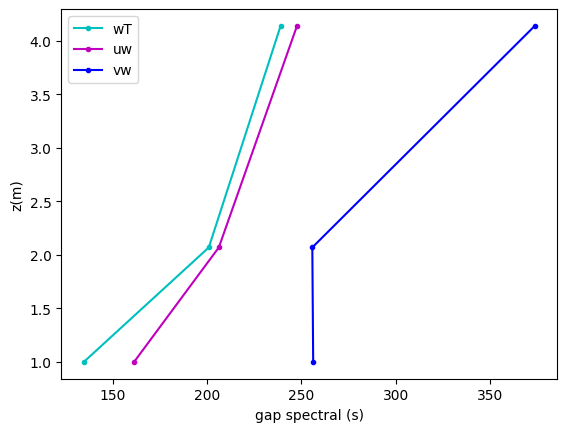

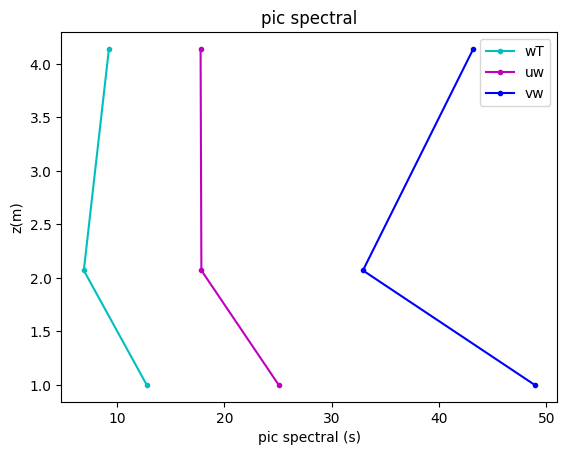

In [24]:
#gap spectral moyen en fonction de la hauteur, pour Ri=(0.0,0.3)
liste_z=np.array([1.0,2.07,4.14])
liste_gap_wT=np.array([gap_spectral_Ds(MRD_wTs_IRGA_1,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['wTs_gap'].values,
                   gap_spectral_Ds(MRD_wTs_IRGA_2,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['wTs_gap'].values,
                   gap_spectral_Ds(MRD_wTs_IRGA_3,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['wTs_gap'].values])
liste_pic_wT=np.array([gap_spectral_Ds(MRD_wTs_IRGA_1,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['wTs_pic'].values,
                   gap_spectral_Ds(MRD_wTs_IRGA_2,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['wTs_pic'].values,
                   gap_spectral_Ds(MRD_wTs_IRGA_3,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['wTs_pic'].values])

gap_wq_moy=gap_wq['wq_gap'].sel(Ri=slice(0.0,0.3)).mean('Ri').values
gap_wq_std=gap_wq['wq_gap'].sel(Ri=slice(0.0,0.3)).std('Ri').values

pic_wq_moy=gap_wq['wq_pic'].sel(Ri=slice(0.0,0.3)).mean('Ri').values
pic_wq_std=gap_wq['wq_pic'].sel(Ri=slice(0.0,0.3)).std('Ri').values

fit_wT=np.polyfit(liste_z,liste_gap_wT,1)
a=fit_wT[0]
b=fit_wT[1]

gap_wq_med=gap_wq['wq_gap'].sel(Ri=slice(0.0,0.3)).median('Ri').values
gap_wq_iqr=gap_wq['wq_gap'].sel(Ri=slice(0.0,0.3)).quantile(0.75,'Ri').values-gap_wq['wq_gap'].sel(Ri=slice(0.0,0.3)).quantile(0.25,'Ri').values

pic_wq_med=gap_wq['wq_pic'].sel(Ri=slice(0.0,0.3)).median('Ri').values
pic_wq_iqr=gap_wq['wq_pic'].sel(Ri=slice(0.0,0.3)).quantile(0.75,'Ri').values-gap_wq['wq_pic'].sel(Ri=slice(0.0,0.3)).quantile(0.25,'Ri').values

z_fit=(liste_gap_wT-b)/a

print(f"gap spectral wq moyen : {gap_wq_moy} s, ecart type {gap_wq_std}")
print(f"pic spectral wq moyen : {pic_wq_moy} s, ecart type {pic_wq_std}")

print(f"gap spectral wq median : {gap_wq_med} s, IQR {gap_wq_iqr}")
print(f"pic spectral wq median : {pic_wq_med} s, IQR {pic_wq_iqr}")

print(f"fit lineaire gap wT : gap(z)={np.round(a,3)}*z+{np.round(b,3)}")

liste_gap_uw=np.array([gap_spectral_Ds(MRD_uw_IRGA_1,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['uw_gap'].values,
                   gap_spectral_Ds(MRD_uw_IRGA_2,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['uw_gap'].values,
                   gap_spectral_Ds(MRD_uw_IRGA_3,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['uw_gap'].values])

liste_pic_uw=np.array([gap_spectral_Ds(MRD_uw_IRGA_1,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['uw_pic'].values,
                   gap_spectral_Ds(MRD_uw_IRGA_2,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['uw_pic'].values,
                   gap_spectral_Ds(MRD_uw_IRGA_3,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['uw_pic'].values])

liste_gap_vw=np.array([gap_spectral_Ds(MRD_vw_IRGA_1,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['vw_gap'].values,
                   gap_spectral_Ds(MRD_vw_IRGA_2,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['vw_gap'].values,
                   gap_spectral_Ds(MRD_vw_IRGA_3,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['vw_gap'].values])

liste_pic_vw=np.array([gap_spectral_Ds(MRD_vw_IRGA_1,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['vw_pic'].values,
                   gap_spectral_Ds(MRD_vw_IRGA_2,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['vw_pic'].values,
                   gap_spectral_Ds(MRD_vw_IRGA_3,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['vw_pic'].values])

liste_gap_uv=np.array([gap_spectral_Ds(MRD_uv_IRGA_1,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['uv_gap'].values,
                   gap_spectral_Ds(MRD_uv_IRGA_2,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['uv_gap'].values,
                   gap_spectral_Ds(MRD_uv_IRGA_3,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['uv_gap'].values])

liste_pic_uv=np.array([gap_spectral_Ds(MRD_uv_IRGA_1,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['uv_pic'].values,
                   gap_spectral_Ds(MRD_uv_IRGA_2,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['uv_pic'].values,
                   gap_spectral_Ds(MRD_uv_IRGA_3,'Ri').sel(Ri=slice(0.0,0.3)).mean('Ri')['uv_pic'].values])


fig=plt.figure()
#plt.title("gap spectral")
plt.plot(liste_gap_wT,liste_z,color='c',label='wT',marker='.')
plt.plot(liste_gap_uw,liste_z,color='m',label='uw',marker='.')
plt.plot(liste_gap_vw,liste_z,color='b',label='vw',marker='.')
#plt.plot(liste_gap_uv,liste_z,color='k',label='uv',marker='.')
#plt.plot(a*liste_z+b,liste_z,color='c',linestyle='-.',label='fit gap wT')
plt.legend()
plt.xlabel("gap spectral (s)")
plt.ylabel("z(m)")
plt.savefig(repertoire_figures+"gap_z.png")
#plt.xscale('log')
#plt.yscale("log")

fig=plt.figure()
plt.title("pic spectral")
plt.plot(liste_pic_wT,liste_z,color='c',label='wT',marker='.')
plt.plot(liste_pic_uw,liste_z,color='m',label='uw',marker='.')
plt.plot(liste_pic_vw,liste_z,color='b',label='vw',marker='.')
#plt.plot(liste_pic_uv,liste_z,color='k',label='uv',marker='.')
plt.xlabel("pic spectral (s)")
plt.ylabel("z(m)")
plt.legend()
plt.savefig(repertoire_figures+"pic_z.png")

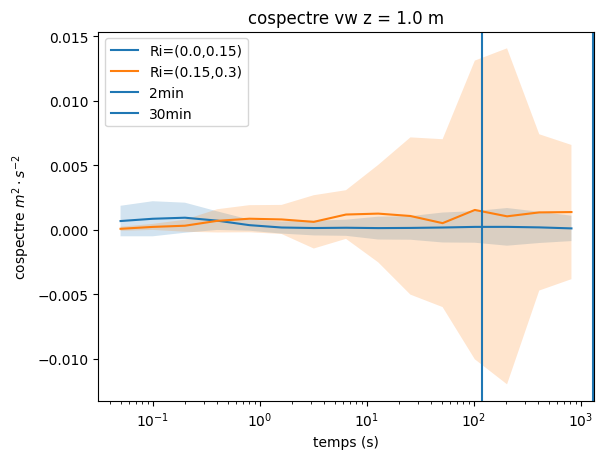

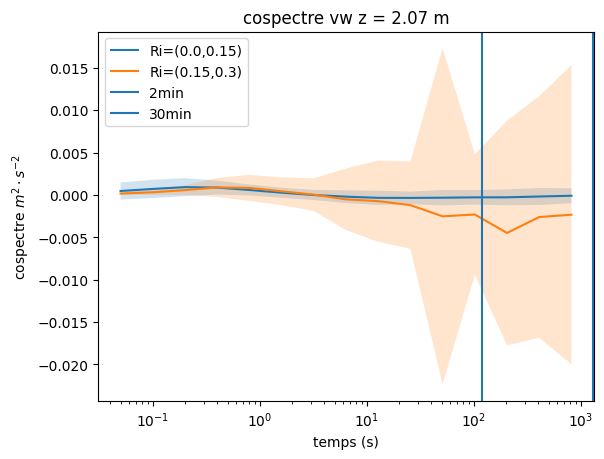

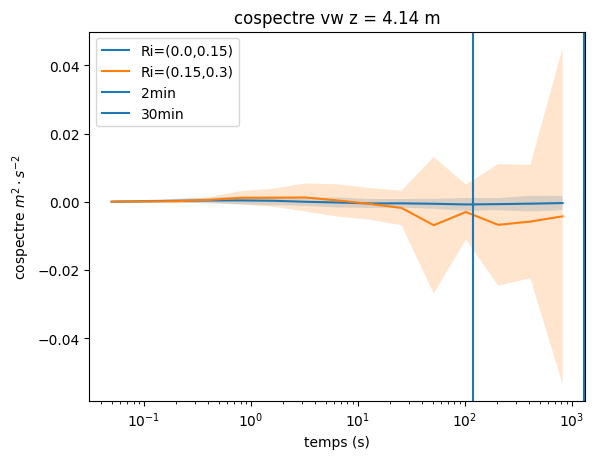

In [25]:
vw_1_bins=MRD_vw_IRGA_1.groupby_bins('Ri',bins_Ri,squeeze=True)
vw_2_bins=MRD_vw_IRGA_2.groupby_bins('Ri',bins_Ri,squeeze=True)
vw_3_bins=MRD_vw_IRGA_3.groupby_bins('Ri',bins_Ri,squeeze=True)


fig=plt.figure()
plt.title("cospectre vw z = "+str(IRGA_1_segments['z'])+" m")
plot_MRD_bins(vw_1_bins,'vw','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
plt.savefig(repertoire_figures+"MRD_vw_1_.png")

fig=plt.figure()
plt.title("cospectre vw z = "+str(IRGA_2_segments['z'])+" m")
plot_MRD_bins(vw_2_bins,'vw','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
plt.savefig(repertoire_figures+"MRD_vw_2_.png")
fig=plt.figure()
plt.title("cospectre vw z = "+str(IRGA_3_segments['z'])+" m")
plot_MRD_bins(vw_3_bins,'vw','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
plt.savefig(repertoire_figures+"MRD_vw_3_.png")

Text(0, 0.5, 'cospectre $ m^2 \\cdot s^{-2}$')

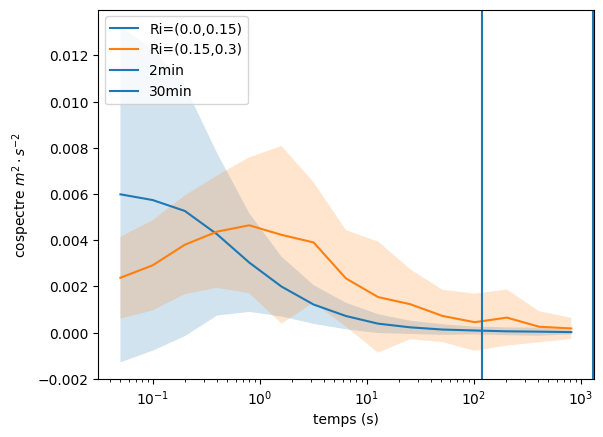

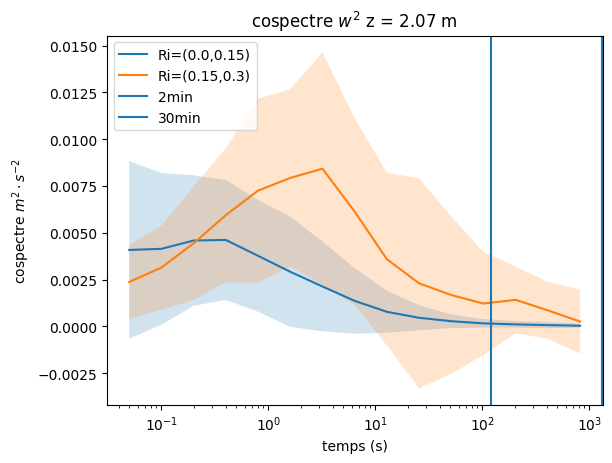

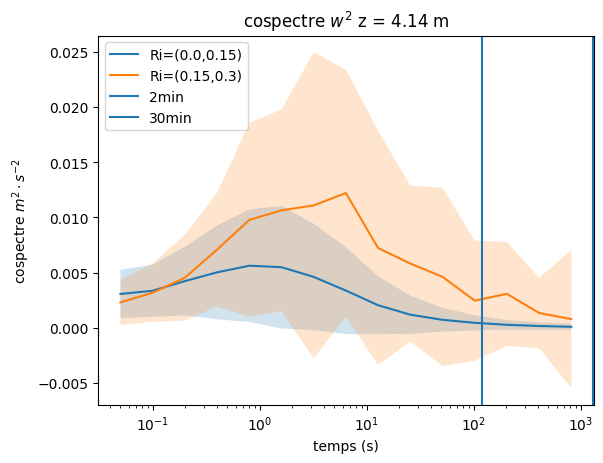

In [26]:
fig=plt.figure()
#plt.title(r"cospectre $w^2$ z = "+str(IRGA_1_segments['z'])+" m")
plot_MRD_bins(uw_1_bins,'w','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
plt.savefig(repertoire_figures+"MRD_w2_1.png")

fig=plt.figure()
plt.title(r"cospectre $w^2$ z = "+str(IRGA_2_segments['z'])+" m")
plot_MRD_bins(uw_2_bins,'w','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
#plt.savefig(repertoire_figures+"MRD_w2_2.png")

fig=plt.figure()
plt.title(r"cospectre $w^2$ z = "+str(IRGA_3_segments['z'])+" m")
plot_MRD_bins(uw_3_bins,'w','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
#plt.savefig(repertoire_figures+"MRD_w2_3.png")

Text(0, 0.5, 'cospectre $ m^2 \\cdot s^{-2}$')

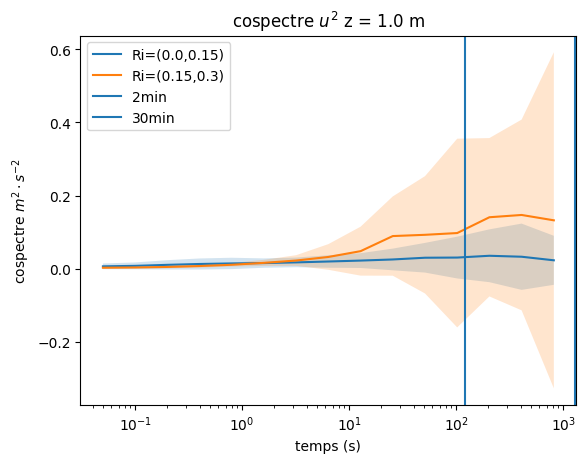

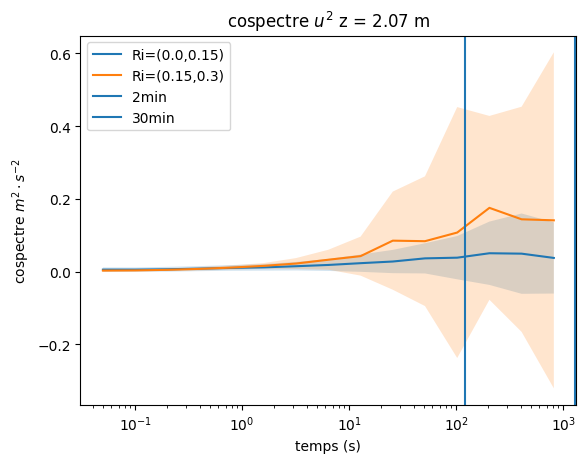

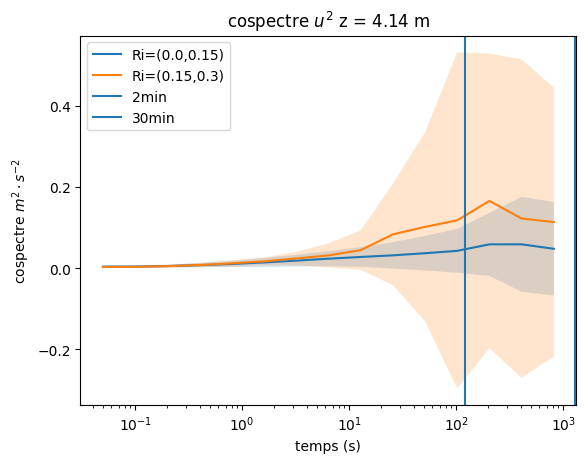

In [27]:
fig=plt.figure()
plt.title(r"cospectre $u^2$ z = "+str(IRGA_1_segments['z'])+" m")
plot_MRD_bins(uw_1_bins,'u','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
#plt.ylim(0.0,0.05)
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")

#plt.savefig(repertoire_figures+"MRD_u2_1.png")

fig=plt.figure()
plt.title(r"cospectre $u^2$ z = "+str(IRGA_2_segments['z'])+" m")
plot_MRD_bins(uw_2_bins,'u','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
#plt.savefig(repertoire_figures+"MRD_u2_2.png")

fig=plt.figure()
plt.title(r"cospectre $u^2$ z = "+str(IRGA_3_segments['z'])+" m")
plot_MRD_bins(uw_3_bins,'u','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
#plt.savefig(repertoire_figures+"MRD_u2_3.png")

Text(0, 0.5, 'cospectre $ m^2 \\cdot s^{-2}$')

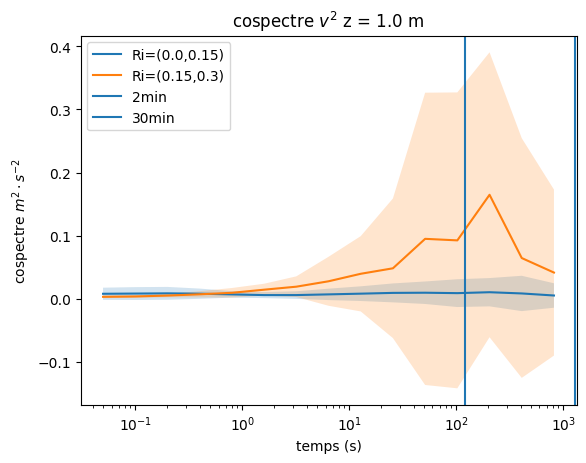

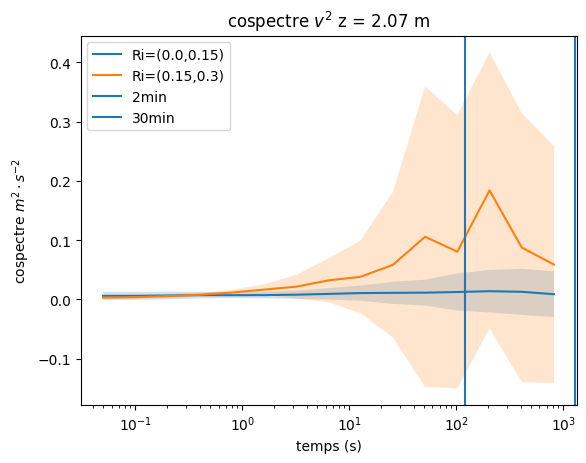

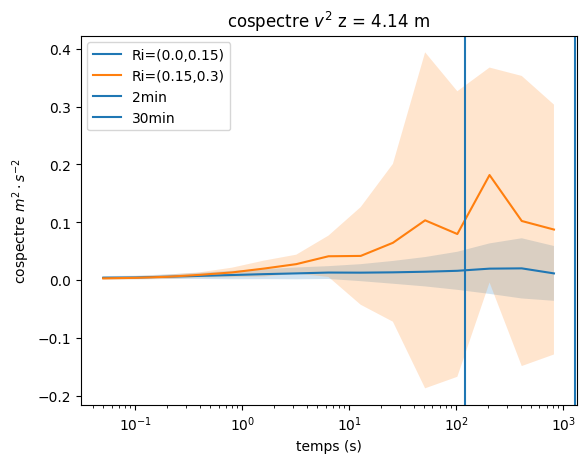

In [28]:
fig=plt.figure()
plt.title(r"cospectre $v^2$ z = "+str(IRGA_1_segments['z'])+" m")
plot_MRD_bins(vw_1_bins,'v','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
plt.savefig(repertoire_figures+"MRD_u2_1.png")
fig=plt.figure()
plt.title(r"cospectre $v^2$ z = "+str(IRGA_2_segments['z'])+" m")
plot_MRD_bins(vw_2_bins,'v','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
#plt.savefig(repertoire_figures+"MRD_u2_2.png")

fig=plt.figure()
plt.title(r"cospectre $v^2$ z = "+str(IRGA_3_segments['z'])+" m")
plot_MRD_bins(vw_3_bins,'v','Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
#plt.savefig(repertoire_figures+"MRD_u2_3.png")

Text(0, 0.5, 'cospectre $ m^2 \\cdot s^{-2}$')

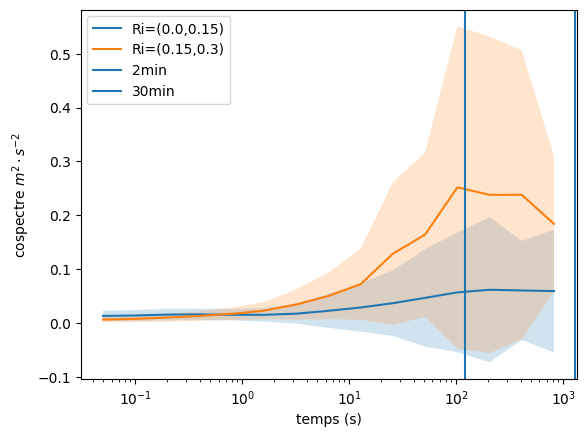

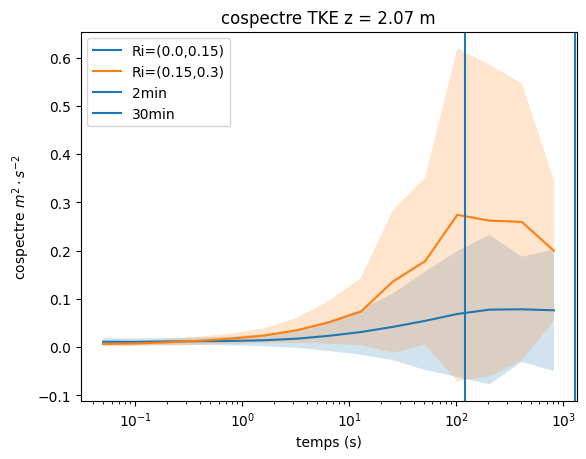

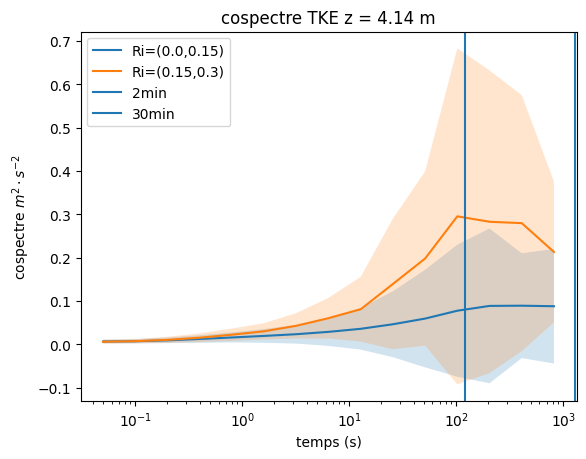

In [29]:
#TKE
Ds_spectre_U_1= 0.5*(MRD_uw_IRGA_1['u']+MRD_uw_IRGA_1['w']+MRD_vw_IRGA_1['v'])
Ds_spectre_U_2= 0.5*(MRD_uw_IRGA_2['u']+MRD_uw_IRGA_1['w']+MRD_vw_IRGA_2['v'])
Ds_spectre_U_3= 0.5*(MRD_uw_IRGA_3['u']+MRD_uw_IRGA_3['w']+MRD_vw_IRGA_3['v'])

Ds_spectre_U_1_bins = Ds_spectre_U_1.groupby_bins('Ri',bins_Ri,squeeze=True)
Ds_spectre_U_2_bins = Ds_spectre_U_2.groupby_bins('Ri',bins_Ri,squeeze=True)
Ds_spectre_U_3_bins = Ds_spectre_U_3.groupby_bins('Ri',bins_Ri,squeeze=True)

def plot_MRD_bins_Da(Da_binned,axis,**kwargs):
    for groups in Da_binned.groups:
        Da_i=Da_binned[groups]
        Da_moy=Da_i.mean(axis).values
        Da_std=Da_i.std(axis).values
        """
        plt.errorbar(Ds_i.coords['temps'].values,
                     Ds_moy,yerr=Ds_std,label=axis+'=('+str(groups.left)+','+str(groups.right)+')',**kwargs)"""
        plt.plot(Da_i.coords['temps'].values,Da_moy,label=axis+'=('+str(groups.left)+','+str(groups.right)+')')
        #                                                              type pandas.interval
        plt.fill_between(Da_i.coords['temps'].values,Da_moy-Da_std,Da_moy+Da_std,alpha=0.2)

fig=plt.figure()
#plt.title(r"cospectre TKE z = "+str(IRGA_1_segments['z'])+" m")
plot_MRD_bins_Da(Ds_spectre_U_1_bins,'Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
plt.savefig(repertoire_figures+"MRD_TKE_1_bins.png")
fig=plt.figure()
plt.title(r"cospectre TKE z = "+str(IRGA_2_segments['z'])+" m")
plot_MRD_bins_Da(Ds_spectre_U_2_bins,'Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
#plt.savefig(repertoire_figures+"MRD_u2_2.png")

fig=plt.figure()
plt.title(r"cospectre TKE z = "+str(IRGA_3_segments['z'])+" m")
plot_MRD_bins_Da(Ds_spectre_U_3_bins,'Ri')
#plot_MRD_bins_gap(wTs_1_bins,wTs_1_gap,'wTs','Ri')
plt.xscale('log')
plt.axvline(120,label="2min")
plt.axvline(1300,label="30min")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre $ m^2 \cdot s^{-2}$")
#plt.savefig(repertoire_figures+"MRD_u2_3.png")

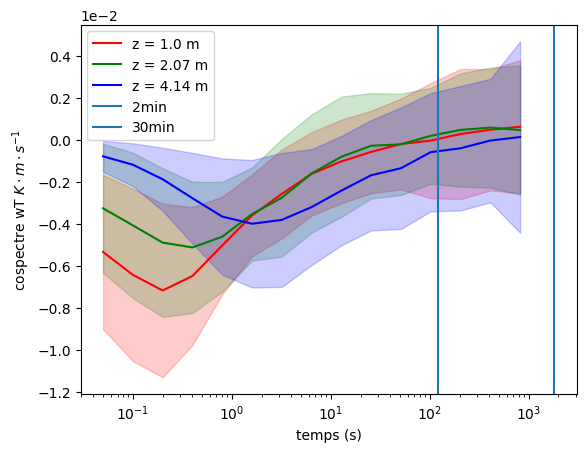

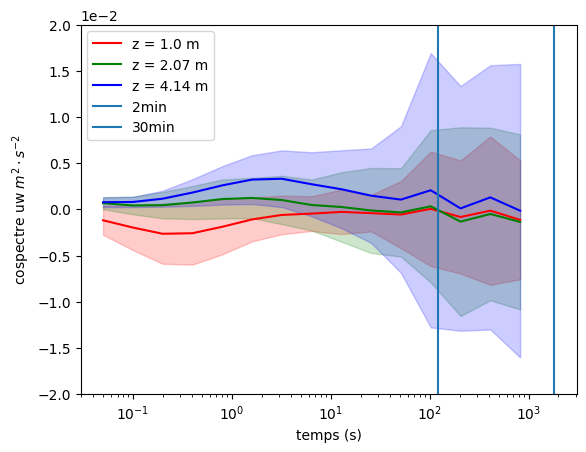

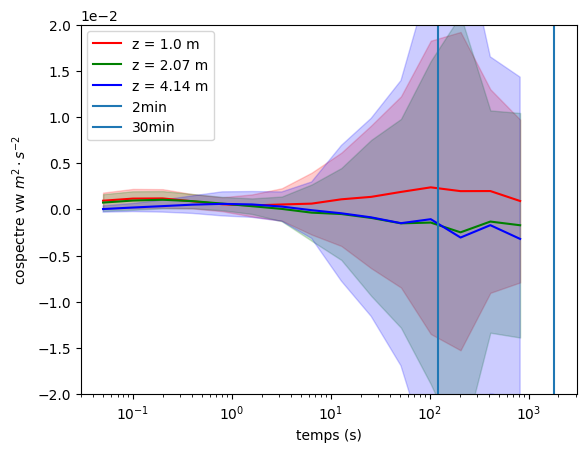

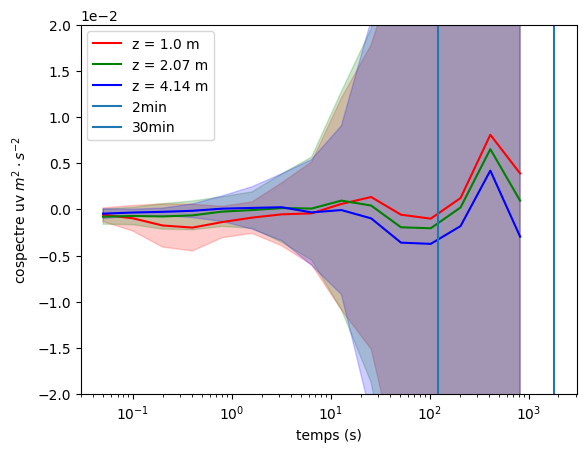

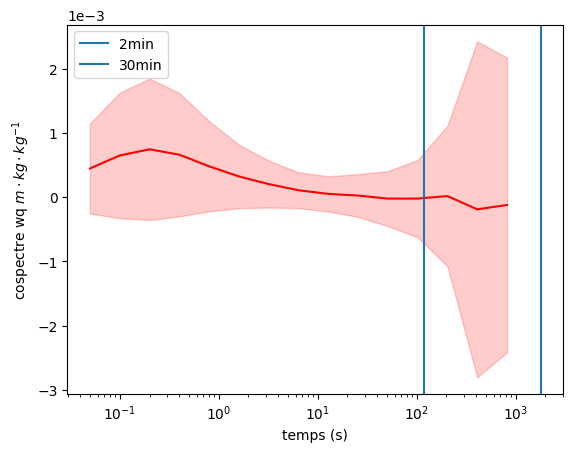

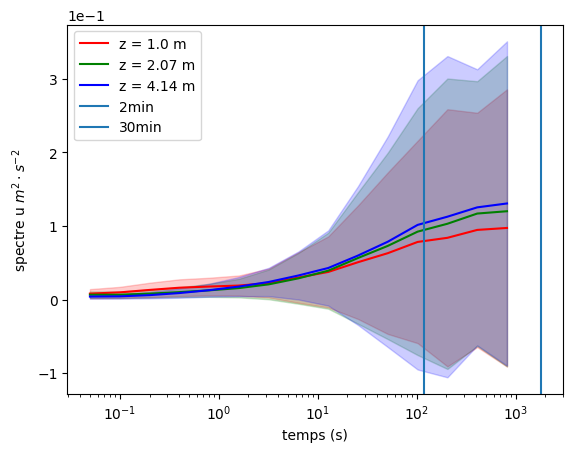

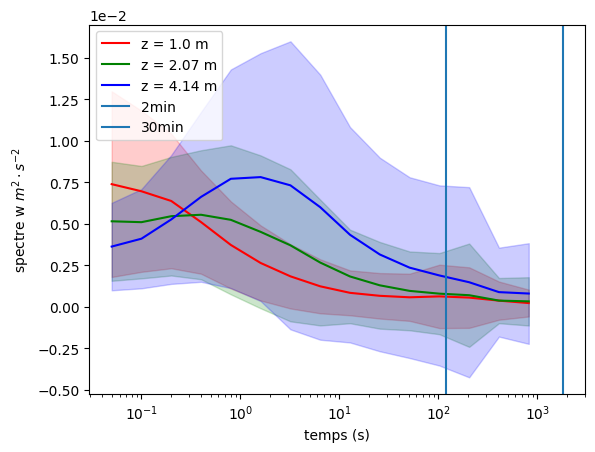

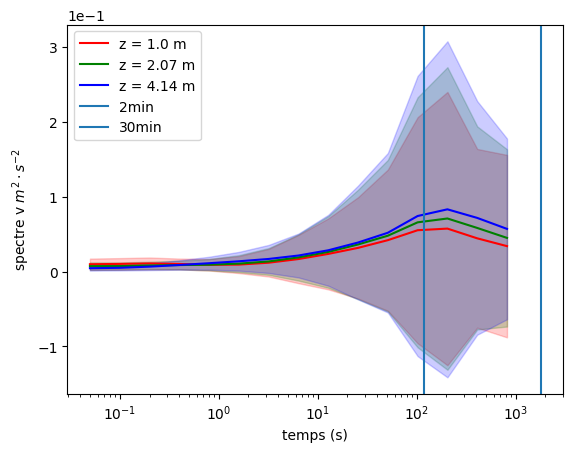

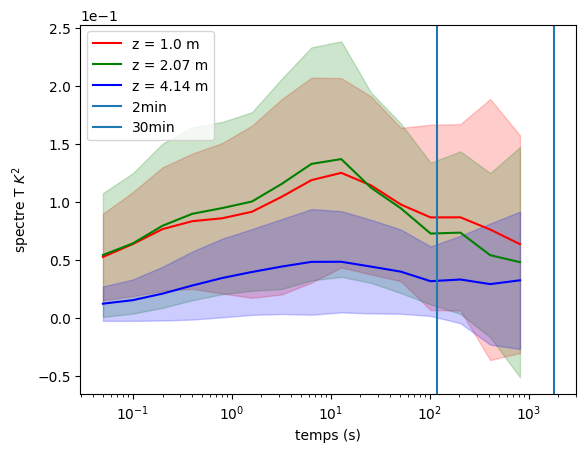

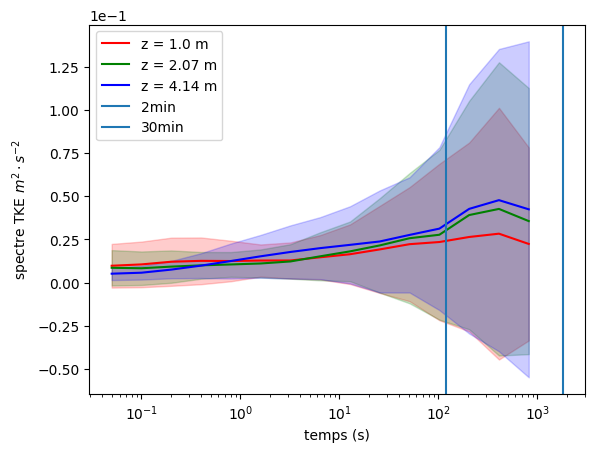

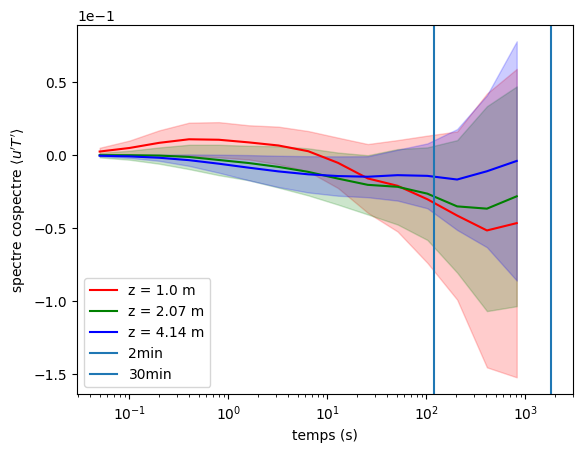

In [36]:
#tracé des spectres uniquement pour Ri dans l'intervalle (0,0.1)
def plot_spectre(Ds,var,R_min=0.0,R_max=0.3,couleur='b',texte=None):
    Ds_trunc=Ds.sel(Ri=slice(R_min,R_max))
    Ds_trunc_moy=Ds_trunc.mean('Ri')
    #Ds_trunc_moy=Ds_trunc.median('Ri')
    Ds_trunc_std=Ds_trunc.std('Ri')
    #Ds_trunc_std=Ds_trunc.quantile(0.75,'Ri')-Ds_trunc.quantile(0.25,'Ri')
    tps=Ds_trunc.coords['temps'].values
    plt.plot(tps,Ds_trunc_moy[var].values,color=couleur,label=texte)
    plt.fill_between(tps,
                     Ds_trunc_moy[var].values-Ds_trunc_std[var].values,
                     Ds_trunc_moy[var].values+Ds_trunc_std[var].values,alpha=0.2,color=couleur)
def plot_spectre_Da(Da,R_min=0.0,R_max=0.3,couleur='b',texte=None):
    Da_trunc=Da.sel(Ri=slice(R_min,R_max))
    #Da_trunc_moy=Da_trunc.mean('Ri')
    Da_trunc_moy=Da_trunc.median('Ri')
    #Da_trunc_std=Da_trunc.std('Ri')
    Da_trunc_std=Da_trunc.quantile(0.75,'Ri')-Da_trunc.quantile(0.25,'Ri')
    tps=Da_trunc.coords['temps'].values
    plt.plot(tps,Da_trunc_moy.values,color=couleur,label=texte)
    plt.fill_between(tps,
                     Da_trunc_moy.values-Da_trunc_std.values,
                     Da_trunc_moy.values+Da_trunc_std.values,alpha=0.2,color=couleur)

fig=plt.figure()
plot_spectre(MRD_wTs_IRGA_1,'wTs',couleur='r',texte="z = "+str(IRGA_1_segments['z'])+" m")
plot_spectre(MRD_wTs_IRGA_2,'wTs',couleur='g',texte="z = "+str(IRGA_2_segments['z'])+" m")
plot_spectre(MRD_wTs_IRGA_3,'wTs',couleur='b',texte="z = "+str(IRGA_3_segments['z'])+" m")
plt.xscale('log')
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre wT $K\cdot m \cdot s^{-1}$")
plt.axvline(120,label="2min")
plt.axvline(1800,label="30min")
plt.legend()
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
plt.savefig(repertoire_figures+"MRD_wT_all.png")

fig=plt.figure()
plot_spectre(MRD_uw_IRGA_1,'uw',couleur='r',texte="z = "+str(IRGA_1_segments['z'])+" m")
plot_spectre(MRD_uw_IRGA_2,'uw',couleur='g',texte="z = "+str(IRGA_2_segments['z'])+" m")
plot_spectre(MRD_uw_IRGA_3,'uw',couleur='b',texte="z = "+str(IRGA_3_segments['z'])+" m")
plt.xscale('log')
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre uw $ m^2 \cdot s^{-2}$")
plt.axvline(120,label="2min")
plt.ylim(-0.02,0.02)
plt.axvline(1800,label="30min")
plt.legend()
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
plt.savefig(repertoire_figures+"MRD_uw_all.png")


fig=plt.figure()
plot_spectre(MRD_vw_IRGA_1,'vw',couleur='r',texte="z = "+str(IRGA_1_segments['z'])+" m")
plot_spectre(MRD_vw_IRGA_2,'vw',couleur='g',texte="z = "+str(IRGA_2_segments['z'])+" m")
plot_spectre(MRD_vw_IRGA_3,'vw',couleur='b',texte="z = "+str(IRGA_3_segments['z'])+" m")
plt.xscale('log')
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre vw $ m^2 \cdot s^{-2}$")
plt.axvline(120,label="2min")
plt.axvline(1800,label="30min")
plt.ylim(-0.02,0.02)
plt.legend()
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
plt.savefig(repertoire_figures+"MRD_vw_all.png")

fig=plt.figure()
plot_spectre(MRD_uv_IRGA_1,'uv',couleur='r',texte="z = "+str(IRGA_1_segments['z'])+" m")
plot_spectre(MRD_uv_IRGA_2,'uv',couleur='g',texte="z = "+str(IRGA_2_segments['z'])+" m")
plot_spectre(MRD_uv_IRGA_3,'uv',couleur='b',texte="z = "+str(IRGA_3_segments['z'])+" m")
plt.xscale('log')
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre uv $ m^2 \cdot s^{-2}$")
plt.axvline(120,label="2min")
plt.axvline(1800,label="30min")
plt.ylim(-0.02,0.02)
plt.legend()
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
plt.savefig(repertoire_figures+"MRD_uv_all.png")



fig=plt.figure()
plot_spectre(MRD_wq_IRGA_1,'wq',couleur='r')
plt.xscale('log')
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre wq $ m \cdot kg\cdot kg^{-1}$")
plt.axvline(120,label="2min")
plt.axvline(1800,label="30min")
#plt.ylim(-0.05,0.05)
plt.legend()
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
plt.savefig(repertoire_figures+"MRD_wq_all.png")

fig=plt.figure()
plot_spectre(MRD_uw_IRGA_1,'u',couleur='r',texte="z = "+str(IRGA_1_segments['z'])+" m")
plot_spectre(MRD_uw_IRGA_2,'u',couleur='g',texte="z = "+str(IRGA_2_segments['z'])+" m")
plot_spectre(MRD_uw_IRGA_3,'u',couleur='b',texte="z = "+str(IRGA_3_segments['z'])+" m")
plt.xscale('log')
plt.xlabel("temps (s)")
plt.ylabel(r"spectre u $ m^2 \cdot s^{-2}$")
plt.axvline(120,label="2min")
plt.axvline(1800,label="30min")
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
plt.legend()
plt.savefig(repertoire_figures+"MRD_u2_all.png")

fig=plt.figure()
plot_spectre(MRD_uw_IRGA_1,'w',couleur='r',texte="z = "+str(IRGA_1_segments['z'])+" m")
plot_spectre(MRD_uw_IRGA_2,'w',couleur='g',texte="z = "+str(IRGA_2_segments['z'])+" m")
plot_spectre(MRD_uw_IRGA_3,'w',couleur='b',texte="z = "+str(IRGA_3_segments['z'])+" m")
plt.xscale('log')
plt.xlabel("temps (s)")
plt.ylabel(r"spectre w $ m^2 \cdot s^{-2}$")
plt.axvline(120,label="2min")
plt.axvline(1800,label="30min")
plt.legend()
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
plt.savefig(repertoire_figures+"MRD_w2_all.png")


fig=plt.figure()
plot_spectre(MRD_vw_IRGA_1,'v',couleur='r',texte="z = "+str(IRGA_1_segments['z'])+" m")
plot_spectre(MRD_vw_IRGA_2,'v',couleur='g',texte="z = "+str(IRGA_2_segments['z'])+" m")
plot_spectre(MRD_vw_IRGA_3,'v',couleur='b',texte="z = "+str(IRGA_3_segments['z'])+" m")
plt.xscale('log')
plt.xlabel("temps (s)")
plt.ylabel(r"spectre v $ m^2 \cdot s^{-2}$")
plt.axvline(120,label="2min")
plt.axvline(1800,label="30min")
plt.legend()
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
plt.savefig(repertoire_figures+"MRD_v_all.png")

fig=plt.figure()
plot_spectre(MRD_wTs_IRGA_1,'Ts',couleur='r',texte="z = "+str(IRGA_1_segments['z'])+" m")
plot_spectre(MRD_wTs_IRGA_2,'Ts',couleur='g',texte="z = "+str(IRGA_2_segments['z'])+" m")
plot_spectre(MRD_wTs_IRGA_3,'Ts',couleur='b',texte="z = "+str(IRGA_3_segments['z'])+" m")
plt.xscale('log')
plt.xlabel("temps (s)")
plt.ylabel(r"spectre T $ K^2 $")
plt.axvline(120,label="2min")
plt.axvline(1800,label="30min")
plt.legend()
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
plt.savefig(repertoire_figures+"MRD_T_all.png")




fig=plt.figure()
plot_spectre_Da(Ds_spectre_U_1,couleur='r',texte="z = "+str(IRGA_1_segments['z'])+" m")
plot_spectre_Da(Ds_spectre_U_2,couleur='g',texte="z = "+str(IRGA_2_segments['z'])+" m")
plot_spectre_Da(Ds_spectre_U_3,couleur='b',texte="z = "+str(IRGA_3_segments['z'])+" m")
plt.xscale('log')
#plt.yscale('log')
plt.xlabel("temps (s)")
plt.ylabel(r"spectre TKE $ m^2 \cdot s^{-2}$")
plt.axvline(120,label="2min")
plt.axvline(1800,label="30min")
plt.legend()
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
plt.savefig(repertoire_figures+"MRD_TKE_all.png")


fig=plt.figure()
plot_spectre(MRD_uT_IRGA_1,'uTs',couleur='r',texte="z = "+str(IRGA_1_segments['z'])+" m")
plot_spectre(MRD_uT_IRGA_2,'uTs',couleur='g',texte="z = "+str(IRGA_2_segments['z'])+" m")
plot_spectre(MRD_uT_IRGA_3,'uTs',couleur='b',texte="z = "+str(IRGA_3_segments['z'])+" m")
plt.xscale('log')
#plt.yscale('log')
plt.xlabel("temps (s)")
plt.ylabel(r"spectre cospectre $\langle u'T' \rangle$")
plt.axvline(120,label="2min")
plt.axvline(1800,label="30min")
plt.legend()
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 


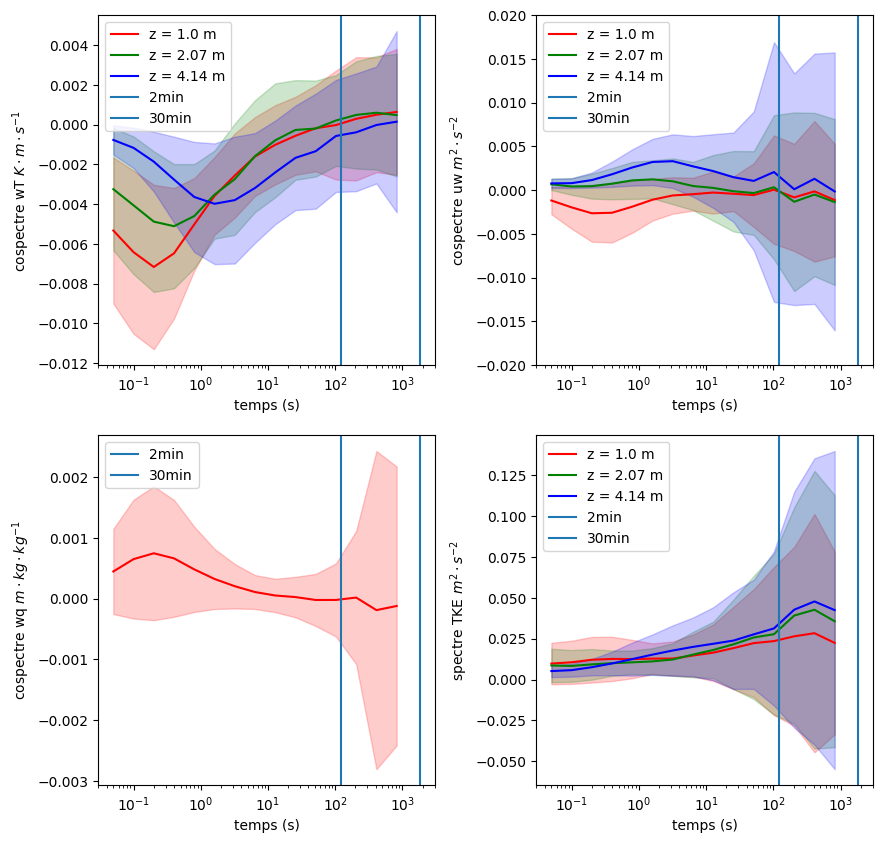

In [35]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.3)
ax1=fig.add_subplot(221)
plot_spectre(MRD_wTs_IRGA_1,'wTs',couleur='r',texte="z = "+str(IRGA_1_segments['z'])+" m")
plot_spectre(MRD_wTs_IRGA_2,'wTs',couleur='g',texte="z = "+str(IRGA_2_segments['z'])+" m")
plot_spectre(MRD_wTs_IRGA_3,'wTs',couleur='b',texte="z = "+str(IRGA_3_segments['z'])+" m")
plt.xscale('log')
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre wT $K\cdot m \cdot s^{-1}$")
plt.axvline(120,label="2min")
plt.axvline(1800,label="30min")
plt.legend()
#plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 

ax2=fig.add_subplot(222)

plot_spectre(MRD_uw_IRGA_1,'uw',couleur='r',texte="z = "+str(IRGA_1_segments['z'])+" m")
plot_spectre(MRD_uw_IRGA_2,'uw',couleur='g',texte="z = "+str(IRGA_2_segments['z'])+" m")
plot_spectre(MRD_uw_IRGA_3,'uw',couleur='b',texte="z = "+str(IRGA_3_segments['z'])+" m")
plt.xscale('log')
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre uw $ m^2 \cdot s^{-2}$")
plt.axvline(120,label="2min")
plt.ylim(-0.02,0.02)
plt.axvline(1800,label="30min")
plt.legend()

ax3=fig.add_subplot(223)
plot_spectre(MRD_wq_IRGA_1,'wq',couleur='r')
plt.xscale('log')
plt.xlabel("temps (s)")
plt.ylabel(r"cospectre wq $ m \cdot kg\cdot kg^{-1}$")
plt.axvline(120,label="2min")
plt.axvline(1800,label="30min")
#plt.ylim(-0.05,0.05)
plt.legend()


ax4=fig.add_subplot(224)
plot_spectre_Da(Ds_spectre_U_1,couleur='r',texte="z = "+str(IRGA_1_segments['z'])+" m")
plot_spectre_Da(Ds_spectre_U_2,couleur='g',texte="z = "+str(IRGA_2_segments['z'])+" m")
plot_spectre_Da(Ds_spectre_U_3,couleur='b',texte="z = "+str(IRGA_3_segments['z'])+" m")
plt.xscale('log')
#plt.yscale('log')
plt.xlabel("temps (s)")
plt.ylabel(r"spectre TKE $ m^2 \cdot s^{-2}$")
plt.axvline(120,label="2min")
plt.axvline(1800,label="30min")
plt.legend()
plt.savefig(repertoire_figures+"MRD_TKE_all.png")

In [ ]:
dic={'toto':[[34,45],[67,89],[56,89]],'tata':[[67,45],[89,8],[76,100]]}
Ds_test=xr.Dataset(data_vars={key:(('y','x'),dic[key]) for key in dic.keys()},
                 coords={"y":[56,78,89],"x":[90,78]})
print(Ds_test)
print(Ds_test['toto'].values)
print(Ds_test['tata'].values)
print(Ds_test.isel({'y':0}))


In [ ]:
def res_MRD_to_xarray(res_MRD,name_coords='index',values_coords=None):
    """
    convertit un resultats_MRD en dataset xarray, de dimension 2 (temps, Ri)
    name_coords : nom de la coordonnée à ajouter
    values_coords :valeur
    ça sert à assigner une valeur de Ri à chaque segment
    """
    dic_variables=copy.deepcopy(res_MRD)
    temps=copy.deepcopy(res_MRD['temps'])
    del dic_variables['temps']
    if isinstance(values_coords,list) or isinstance(values_coords,np.ndarray):
        #Attention à l'ordre dans lequel on 
        Ds=xr.Dataset(data_vars={key:([name_coords,'temps'],dic_variables[key]) for key in dic_variables.keys()},
                      coords={'temps':temps,name_coords:values_coords})
    else:
        Ds=xr.Dataset(data_vars={key:([name_coords,'temps'],dic_variables[key]) for key in dic_variables.keys()},
                      coords={'temps':temps,name_coords:np.arange(len(temps))})
    return Ds

IRGA_1_wTs=res_MRD_to_xarray(MRD_wTs_IRGA_1,'Ri',IRGA_1_moy['Ri'])
IRGA_2_wTs=res_MRD_to_xarray(MRD_wTs_IRGA_2,'Ri',IRGA_2_moy['Ri'])
IRGA_3_wTs=res_MRD_to_xarray(MRD_wTs_IRGA_3,'Ri',IRGA_3_moy['Ri'])

IRGA_1_uw=res_MRD_to_xarray(MRD_uw_IRGA_1,'Ri',IRGA_1_moy['Ri'])
IRGA_2_uw=res_MRD_to_xarray(MRD_uw_IRGA_2,'Ri',IRGA_2_moy['Ri'])
IRGA_3_uw=res_MRD_to_xarray(MRD_uw_IRGA_3,'Ri',IRGA_3_moy['Ri'])

IRGA_1_vw=res_MRD_to_xarray(MRD_vw_IRGA_1,'Ri',IRGA_1_moy['Ri'])
IRGA_2_vw=res_MRD_to_xarray(MRD_vw_IRGA_2,'Ri',IRGA_2_moy['Ri'])
IRGA_3_vw=res_MRD_to_xarray(MRD_vw_IRGA_3,'Ri',IRGA_3_moy['Ri'])
print(IRGA_1_wTs)

In [ ]:
#petit rappel : theta POSITIF: rotation dans le sens ANTIHORAIRE
#               theta NEGATIF: rotation dans le sens HORAIRE
def rotation(x,y,theta):#theta en degrés
    theta_rad=np.radians(theta)
    cos_theta=np.cos(theta_rad)
    sin_theta=np.sin(theta_rad)
    return x*cos_theta-y*sin_theta,x*sin_theta+y*cos_theta
def angle(x,y):
    return np.degrees(np.arctan(y/x))
def rotation_level(level, orientation):
    new_level=copy.deepcopy(level)
    u_rot,v_rot=rotation(new_level['u'],new_level['v'],orientation)
    new_level['u']=u_rot
    new_level['v']=v_rot
    new_level['dir']=orientation
    return new_level
x=1.1
y=2
print(f"angle(x,y) : {angle(x,y)}")
theta_rot=-15
x_rot,y_rot=rotation(x,y,theta_rot)
print(f"rotation d'un angle {theta_rot}")
print(f"angle final {angle(x_rot,y_rot)}")
dic={'u':np.array([1,2,3]),'v':np.array([6,9,8]),'w':np.array([6,3,0]),'H':42}
print(f" dic avant rotatin {dic}")
print(f" dic apres rotation : {rotation_level(dic,45)}")
print(f"dic {dic}")
plt.scatter(x,y,color='b',label='avant rotation')
plt.scatter(x_rot,y_rot,color='r',label='apres rotation')
plt.legend()

In [ ]:
def f(x,progress=False):
    iter=range(0,10)
    if progress==True:
        iter=tqdm(iter)
    for i in iter:
        print(i)
        clk.sleep(0.1)
f(10,True)

In [ ]:
#rearrangement d'un tableau de façon aléatoire
a=np.array([1,3,4,5,6,9])
b=np.copy(a)
index_aleat=np.array([])
print(f"a {a}")
cpt=0 
for i in range(0,a.size):
    #int_aleat=np.random.randint(low=0,high=a.size)
    while int_aleat in index_aleat:
        int_aleat=np.random.randint(low=0,high=a.size)
    index_aleat=np.append(index_aleat,int_aleat)
    b[i]=a[int_aleat]
print(f"b {b}")
print(f"index_aleat {index_aleat}")

In [ ]:
func=lambda x:x**2
func2=func
func=lambda x:x**3
print(func(2))
print(func2(4))

In [ ]:
x=np.linspace(1,10)
plt.plot(x,np.exp(x))
plt.xscale('log')
#plt.xscale('log')

In [ ]:
print(__debug__)

In [ ]:

if __debug__:
    print("toto")
else:
    print("tata")

In [ ]:
T=2*np.pi
f=10
N=1000
x=np.linspace(-np.pi,np.pi,N)
y=np.exp(-x)

TF_y=np.fft.rfft(y)
freq=np.fft.rfftfreq(N,1/f)

fig=plt.figure()
plt.plot(freq,TF_y)
plt.xlabel('f(Hz)')
plt.xscale('log')
plt.yscale('log')